### Overall PageRank - by Connections and by Time of Delay
##### Implementation from Scratch

#### I. Import Key Dependencies

In [0]:
from pyspark.sql.functions import *
import pyspark.sql.functions as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from graphframes import *
import geopandas as gpd
import plotly as plotly
from pyspark.sql.functions import coalesce

from functools import reduce
from pyspark.sql import DataFrame


# import custom cv module - for Custome Cross Validation - Timeseries
spark.sparkContext.addPyFile("dbfs:/custom_cv.py")
from custom_cv import CustomCrossValidator

pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", 200)

#Import for implementing upsampling or downsampling
from pyspark.sql.functions import col, explode, array, lit

#from heatmap import heatmap, corrplot
from pyspark.ml import *
from pyspark.ml.linalg import *
from pyspark.ml.stat import *
from pyspark.ml.feature import *
from pyspark.sql.window import *

# Append weights to the dataset
from pyspark.sql.functions import col
from pyspark.sql.functions import when

# ML related libraries
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import StandardScaler, Imputer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import GBTClassifier

from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.classification import RandomForestClassifier
from pyspark.mllib.evaluation import MulticlassMetrics

from pyspark.ml.linalg import Vectors
from itertools import combinations
from pyspark.accumulators import AccumulatorParam

# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from pyspark.sql.functions import lit

#Blob credentials
blob_container = "cemgr14c" # The name of your container created in https://portal.azure.com
storage_account = "cemgr14" #The name of your Storage account created in https://portal.azure.com
secret_scope = "w261gr14" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "keygr14" # The name of the secret key created in your local computer using the Databricks CLI
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

# SAS Token

spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

#### II. Read Data and Select Columns

In [0]:
# READ JOINED DATA
# Load 2015 Q1-2 Joined Data (includes flights, weather, and engineered features)
#df_airlines = spark.read.parquet(f"{blob_url}/complete_join_6_month/*")

# THIS LINK TO UPLOAD THE FULL DATA
df_airlines = spark.read.parquet(f"{blob_url}/airplanes_weather_final_5yr_EZ/*").cache()

# df_airlines.display()

# CHECK FOR BALANCE - LARGE DATASET
df_airlines.groupBy("DEP_DEL15").agg((count(col("DISTANCE"))).alias("COUNT_DISTANCE")).display()

DEP_DEL15 COUNT_DISTANCE 0.0 25565659 null 4744 1.0 5683646

In [0]:
# Reduce the amount of data (to run on DBCE)

# CONTINUE WITH A PORTION OF DATA FOR TESTING
# proportion = 0.025   # 0.025
# (airline_test, airline_rest) = df_airlines.randomSplit([proportion, 1- proportion], seed=123)

#CONTINUE WITH ALL DATA
airline_test = df_airlines

# Select only the columns needed
airline_joins_sel = airline_test.select('YEAR','QUARTER','MONTH','DAY_OF_MONTH','DAY_OF_WEEK',
                                         'OP_CARRIER_AIRLINE_ID', 'ORIGIN_AIRPORT_ID','DEST_AIRPORT_ID',
                                         'CRS_DEP_TIME','DEP_DELAY','DEP_DELAY_NEW','DEP_DEL15','DEP_DELAY_GROUP',
                                         'DISTANCE','DISTANCE_GROUP',
                                         'wind_speed_mps_orig','ceiling_ht_dim_orig','visibility_meters_orig','temp_cels_orig','dew_pt_orig','atmos_press_orig','precip_milimeters_orig',
                                         'wind_speed_mps_dest','ceiling_ht_dim_dest','visibility_meters_dest','temp_cels_dest','dew_pt_dest','atmos_press_dest','precip_milimeters_dest',
                                         'rolling_ninety_day_average','Air_Page_Rank_traffic','Delay_block','OD_delay_pair',
                                         'SEASON','WKDAY','DEPARTURE_Hour_CRS').cache()

# OUTCOME VARIABLES: DEP_TIME  DEP_DEL15
# Print out number of records
print(str(airline_joins_sel.count()) + " Number of records")

# CHECK FOR BALANCE - LARGE DATASET
# airline_joins_sel.groupBy("DEP_DEL15").agg((count(col("DISTANCE"))).alias("COUNT_DISTANCE")).display()

# DROP NA'S
airline_joins_sel = airline_joins_sel.dropna()

# CHECK FOR BALANCE - LARGE DATASET
airline_joins_sel.groupBy("DEP_DEL15").agg((count(col("DISTANCE"))).alias("COUNT_DISTANCE")).display()

31254049 Number of records

DEP_DEL15 COUNT_DISTANCE 0.0 23896118 1.0 5316233

#### II. DELTA LAKE

In [0]:
# FULL DATA = airline_joins_sel

# Configure Path
DELTALAKE_GOLD_PATH = f"{blob_url}/airline_pr_cem.delta"

# Remove table if it exists
dbutils.fs.rm(DELTALAKE_GOLD_PATH, recurse=True)

# Save table as Delta Lake
# USE WHEN TESTING
# df_airline_saved.write.format("delta").mode("overwrite").save(DELTALAKE_GOLD_PATH)

#USE WHEN USING FULL DATA or WITHOUT SAVING
airline_joins_sel.write.format("delta").mode("overwrite").save(DELTALAKE_GOLD_PATH)

# Re-read as Delta Lake
airlines = spark.read.format("delta").load(DELTALAKE_GOLD_PATH)

# Review data
# display(airlines)

# CHECK FOR BALANCE - LARGE DATASET
airlines.groupBy("DEP_DEL15").agg((count(col("DISTANCE"))).alias("COUNT_DISTANCE")).display()

DEP_DEL15 COUNT_DISTANCE 0.0 23896118 1.0 5316233

#### III Page Rank Functions

In [0]:
# INITIALIZE GRAPH
def initGraph(dataRDD):
    """
    Spark job to read in the raw data and initialize an 
    adjacency list representation with a record for each
    node (including dangling nodes).
    
    Returns: 
        graphRDD -  a pair RDD of (node_id , (score, edges))
        
    NOTE: The score should be a float, but you may want to be 
    strategic about how format the edges... there are a few 
    options that can work. Make sure that whatever you choose
    is sufficient for Question 8 where you'll run PageRank.
    """
    
    def parse(line, N):
        node = line[0]
        connections = dict(line[1])
        
        con_set = connections.keys()
        
        yield (node, (1/N, connections))
        
        for con in con_set:
            yield (con, (1/N , {}))
         
    N = sc.broadcast(count_nodes(dataRDD))
    
    graphRDD = dataRDD.flatMap(lambda x: parse(x,N.value)).reduceByKey(lambda x,y : (x[0], x[1] or y[1])).cache()
    
    return graphRDD

In [0]:
def count_nodes(dataRDD):
    """
    Spark job to count the total number of nodes.
    Returns: integer count 
    """    

    def emitPairs(record):
        node = record[0]
        cnns = record[1]
        yield (node, 1)
        for cnn in cnns:
            yield (cnn[0], 1)
      
    total = dataRDD.flatMap(emitPairs).reduceByKey(lambda x,y : x+y).cache()
  
    totalCount = total.count()
    
    return totalCount

In [0]:
class FloatAccumulatorParam(AccumulatorParam):
    """
    Custom accumulator for use in page rank to keep track of various masses.
    
    IMPORTANT: accumulators should only be called inside actions to avoid duplication.
    We stringly recommend you use the 'foreach' action in your implementation below.
    """
    def zero(self, value):
        return value
    def addInPlace(self, val1, val2):
        return val1 + val2

In [0]:
def runPageRank(graphInitRDD, alpha = 0.15, maxIter = 10, verbose = True):
    """
    Spark job to implement page rank
    Args: 
        graphInitRDD  - pair RDD of (node_id , (score, edges))
        alpha         - (float) teleportation factor
        maxIter       - (int) stopping criteria (number of iterations)
        verbose       - (bool) option to print logging info after each iteration
    Returns:
        steadyStateRDD - pair RDD of (node_id, pageRank)
    """
    # teleportation:
    a = sc.broadcast(alpha)
    
    # damping factor:
    d = sc.broadcast(1-a.value)
    
    # initialize accumulators for dangling mass & total mass
    mmAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    totAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    
    # To split and emit node's weight across all connections based on weight for the connection
    def parse(line):
        
        node = line[0]
        weight = line[1][0]
        connections = line[1][1]
        
        #Yield node with connections with a weight of zero - used to consolidate any receiving weight
        yield (node, (0.0, connections))
        
        # To get the total weight for the connections of the node
        tsum = 0
        for con in set(connections.keys()):
            tsum += int(connections[con])
                               
        # To emit assigned weight to connections based on their specific weight
        for con in set(connections.keys()):
            if tsum != 0:
                yield (con, ( weight* (connections[con]/tsum), {}))
                
    # For a node that identified as dangling node, emit a pair with the weight to be later consolidated
    # as weight to be spread across the nodes 
    
    # Function to accumulate mass for dangling nodes used when implemented pure map-reduce task
    def dangling(x):
          if x[1][1] == {}:
            return ("d", x[1][0])
          else:
            return ("d", 0.0)
    
    # Function to only pass dangling nodes mass to foreach function implementing accumulator
    def isdangling(x):
          if x[1][1] == {}:
            return(x[1][0])
          else:
            return(0.0)

    N = sc.broadcast(graphInitRDD.count())
    
    for i in range(maxIter):
        
        tt = graphInitRDD.map(isdangling).foreach(lambda x: mmAccum.add(x))
        m = mmAccum.value
        
        # Calculate PageRank  - (1-alpha)(m/N + sum(p)) + alpha(1/N)
        graphInitRDD = graphInitRDD.flatMap(lambda x: parse(x)) \
                                   .reduceByKey(lambda x,y : (x[0]+y[0], x[1] or y[1])) \
                                   .map(lambda x: (x[0], ( d.value * (x[1][0] + (m/N.value))+ (a.value/N.value), x[1][1] )  )).cache()

        # Initialize accumulator in zero
        mmAccum = sc.accumulator(0.0, FloatAccumulatorParam())
      
        # Check for total mass sum:
        if verbose: 
            tt1 = graphInitRDD.foreach(lambda x: totAccum.add(x[1][0]))
            print("TOTAL MASS: ", totAccum.value)
            totAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    
    # Get the nodes and specific weight as output.
    steadyStateRDD = graphInitRDD.map(lambda x: (x[0], x[1][0]))
    
    return steadyStateRDD

In [0]:
def calc_cnn(x):
    '''
    Input: A rdd graph with 
    '''
    airport = x[0]
    conns = x[1]
    
    Ncnn = len(conns)
    Tflights = 0
    
    for cnn in conns:
        Tflights += cnn[1]
        
    yield (airport, Ncnn, Tflights)

In [0]:
def connections_weight(data):
    '''
    Input: RDD with the following columns -> (Origin Airport, Destinatino Airport, Weight) - where 1 is the weight of a single connection.
    Output: RDD with Origin Airport as key (first element), and a list of connections with the weight
    Example Output: (Origin Airpor, [(Conn1, #Connections1), (Conn2, #Connections2), ... (ConnN,#ConnectionsN)])
    '''
    connections = data.rdd.map(lambda w: ((w[0],w[1]),w[2])) \
                     .reduceByKey(lambda x,y : x + y) \
                     .map(lambda x: (x[0][0], [(x[0][1], x[1])] )) \
                     .reduceByKey(lambda x,y : x + y).cache()
    
    return connections

#### IV. Page Rank based on Number of Connections

Note this is not split by year and time-of-day. In Section IX, we implement a lagged page rank weighted by connections (number of flights) split by year (5 years) and time of day (7 parts of day).

In [0]:
# Select data from datafram - Origin and Destination ID only
airport = airlines.select("ORIGIN_AIRPORT_ID", "DEST_AIRPORT_ID")

# Add a column with 1's - this represent the weight for each instance
airport = airport.withColumn("connection", lit(1)) 
airport.display()

ORIGIN_AIRPORT_ID DEST_AIRPORT_ID connection 13232 13198 1 13232 14679 1 12892 13232 1 10713 14747 1 11057 11252 1 10693 13930 1 10721 10397 1 11298 14908 1 12896 11292 1 13487 11337 1 14771 14893 1 10713 11884 1 12266 14100 1 13930 11278 1 14831 14679 1 12953 13303 1 13061 12266 1 11203 13930 1 11292 13158 1 14869 15016 1 11057 11278 1 14747 11618 1 13796 12954 1 14771 12478 1 14747 13487 1 14262 14107 1 14122 11298 1 14107 11066 1 12951 10397 1 15412 10397 1 13495 10397 1 10397 14747 1 12448 12266 1 13930 12953 1 13232 11042 1 11057 10397 1 14771 12892 1 10721 10397 1 11298 14570 1 11697 13930 1 13851 11298 1 11278 11697 1 14869 15389 1 12280 11292 1 12953 10721 1 11259 13204 1 12191 14683 1 10800 14893 1 11697 12478 1 11298 11193 1 14100 14122 1 11259 12191 1 11298 13891 1 13930 15412 1 11292 14869 1 14107 13930 1 10800 14747 1 12889 14747 1 14814 11298 1 12266 12915 1 13342 13930 1 11292 14122 1 12889 12266 1 11057 15304 1 15024 14100 1 14635 10397 1 12478 11292 1 11203 13930 1 16218 14107 1 14747 11638 1 13264 14869 1 12478 14771 1 14635 11618 1 12339 13204 1 12892 13796 1 11259 12191 1 14100 13487 1 14685 10397 1 11433 15304 1 10397 13360 1 12945 13930 1 14307 12264 1 13487 11423 1 13931 12478 1 14716 12889 1 11057 11423 1 10397 13277 1 10423 10140 1 14747 12478 1 14893 14908 1 15016 13871 1 10693 11481 1 10397 15919 1 11278 10397 1 12173 13830 1 10423 12266 1 13930 15096 1 13204 11697 1 11298 13158 1 12266 11278 1 14107 14893 1 13342 11278 1 11292 12191 1 11298 12266 1 12953 13303 1 13342 14107 1 10397 14747 1 10397 10423 1 10397 11042 1 13930 10599 1 12889 14679 1 14730 10821 1 13930 14771 1 12889 14771 1 14679 14107 1 12954 14869 1 10792 13930 1 10721 12892 1 12892 12266 1 11259 14107 1 10821 11057 1 14492 10397 1 11252 10397 1 11433 11298 1 11697 15304 1 11298 11292 1 14100 11697 1 11986 11433 1 11775 13487 1 13930 14107 1 11292 14679 1 14107 10713 1 11292 14747 1 10821 10397 1 10721 14492 1 12217 10397 1 11298 15411 1 10397 12945 1 12266 13851 1 14771 11292 1 11298 13204 1 11433 10821 1 13342 13930 1 13930 13303 1 12264 12892 1 10423 12478 1 13487 14908 1 12953 13487 1 10397 15304 1 14635 11278 1 14843 15304 1 11292 14683 1 14771 13930 1 14679 14107 1 13930 10529 1 14869 13930 1 14893 12892 1 14679 10397 1 13198 13930 1 12892 12982 1 14057 12889 1 10754 10299 1 14869 11603 1 14869 10397 1 15323 10397 1 12889 10397 1 10800 14771 1 13342 10397 1 13930 14107 1 12953 11057 1 13198 12889 1 14100 11057 1 10397 14747 1 14107 11298 1 11298 10721 1 11298 15304 1 11292 14869 1 13232 11292 1 14100 14122 1 14869 14679 1 13487 12889 1 13204 11278 1 14027 10529 1 12278 10397 1 12953 10397 1 12889 13487 1 14635 13930 1 14107 11259 1 13204 12953 1 12478 12892 1 11697 11433 1 10397 13487 1 12173 13830 1 14771 14747 1 14869 11525 1 14679 11618 1 10693 11278 1 14747 11618 1 14057 10299 1 14679 14771 1 13204 10423 1 13487 11433 1 12953 11042 1 14869 10397 1 10397 11146 1 13296 13204 1 10140 11292 1 13204 11278 1 15016 12889 1 14100 14107 1 14831 13891 1 13303 12478 1 12892 10721 1 12478 15304 1 13487 11042 1 14679 12889 1 11259 11292 1 12173 12758 1 12402 12173 1 12448 12266 1 14100 14771 1 11433 13930 1 14747 14771 1 14771 11298 1 11433 13230 1 11292 13433 1 12892 14679 1 13204 12339 1 12266 15624 1 13487 14457 1 14869 11618 1 10693 14747 1 14057 14831 1 14679 13796 1 12758 12173 1 13204 10721 1 10397 12278 1 10721 10693 1 13830 12892 1 12953 10397 1 11618 14492 1 10397 14747 1 11057 14730 1 11057 10397 1 15304 13232 1 10721 12953 1 11298 14771 1 12892 13487 1 12007 10397 1 10397 10731 1 15380 11433 1 12266 12206 1 14747 10299 1 10299 11630 1 12892 14831 1 11697 10397 1 12266 15304 1 10397 12451 1 15016 14492 1 11292 14893 1 11695 14107 1 12266 11193 1 11298 10599 1 12266 11973 1 13930 14747 1 13930 14747 1 14100 10423 1 12478 11278 1 13930 14492 1 13204 10423 1 12889 14679 1 13930 13342 1 14747 10299 1 10721 14747 1 11057 12451 1 11057 12451 1 14122 10397 1 12889 11433 1 14524 10397 1 11292 14771 1 13930 13204 1 11066 10821 1 14893 1

In [0]:
# Create airportsRDD which includes the following pairs (Origin Airpor, [(Conn1, #Connections1), (Conn2, #Connections2), ... (ConnN,#ConnectionsN)])
airportsRDD = connections_weight(airport).cache()
airportsRDD.collect()

Out[325]: [(11292,
 [(11298, 443192.0),
 (13342, 155703.0),
 (13198, 184031.0),
 (13502, 22304.0),
 (12278, 59014.0),
 (13830, 3563.0),
 (13796, 97671.0),
 (10140, 132954.0),
 (15016, 159872.0),
 (11540, 50843.0),
 (11884, 89226.0),
 (13204, 205892.0),
 (12888, 39174.0),
 (14492, 105047.0),
 (12992, 38608.0),
 (14288, 21759.0),
 (14893, 171392.0),
 (10821, 158872.0),
 (14057, 224740.0),
 (12889, 427364.0),
 (13433, 36833.0),
 (10721, 235317.0),
 (11057, 151015.0),
 (14689, 49427.0),
 (11193, 83399.0),
 (11433, 216650.0),
 (10561, 35984.0),
 (13029, 37988.0),
 (10529, 45106.0),
 (11865, 38213.0),
 (10693, 157842.0),
 (14489, 30364.0),
 (12953, 351025.0),
 (10397, 335008.0),
 (11921, 38973.0),
 (14457, 46407.0),
 (10713, 131189.0),
 (11413, 53659.0),
 (11697, 96291.0),
 (11097, 12271.0),
 (12217, 4497.0),
 (12173, 149.0),
 (12264, 211172.0),
 (14908, 166850.0),
 (15304, 129652.0),
 (13476, 2785.0),
 (14679, 239214.0),
 (13487, 367088.0),
 (14771, 665203.0),
 (14831, 140442.0),
 (14783, 22410.0),
 (13871, 152592.0),
 (13495, 96104.0),
 (14747, 382009.0),
 (13303, 96352.0),
 (13891, 84101.0),
 (11775, 78933.0),
 (12191, 123195.0),
 (11423, 77807.0),
 (11603, 43625.0),
 (11267, 21005.0),
 (12003, 19212.0),
 (12899, 10290.0),
 (13158, 48848.0),
 (11986, 58767.0),
 (11278, 113797.0),
 (11042, 96296.0),
 (12478, 105947.0),
 (11618, 364361.0),
 (13486, 49023.0),
 (14570, 88768.0),
 (15370, 99514.0),
 (14262, 72367.0),
 (14794, 22136.0),
 (10994, 10173.0),
 (11638, 83485.0),
 (15582, 530.0),
 (14122, 79152.0),
 (10558, 12691.0),
 (12266, 283665.0),
 (13930, 485027.0),
 (11066, 77310.0),
 (11122, 25908.0),
 (14698, 18070.0),
 (14730, 43051.0),
 (12094, 15786.0),
 (11503, 30299.0),
 (12339, 143794.0),
 (12255, 36780.0),
 (13851, 146141.0),
 (10599, 5151.0),
 (11003, 57719.0),
 (14543, 35622.0),
 (14635, 17603.0),
 (14307, 3951.0),
 (14869, 432285.0),
 (10849, 72249.0),
 (11109, 204082.0),
 (12389, 30928.0),
 (12441, 38904.0),
 (11637, 68712.0),
 (14193, 4020.0),
 (13485, 54675.0),
 (14237, 209.0),
 (13232, 180862.0),
 (10800, 86468.0),
 (12280, 39438.0),
 (15376, 124328.0),
 (10372, 167972.0),
 (12896, 27097.0),
 (12892, 518333.0),
 (11648, 43411.0),
 (14100, 189383.0),
 (10620, 75858.0),
 (13264, 22527.0),
 (14252, 36679.0),
 (15412, 14124.0),
 (13244, 52681.0),
 (15096, 2049.0),
 (11092, 3438.0),
 (11996, 3335.0),
 (10792, 1681.0),
 (14107, 454993.0),
 (10423, 196456.0),
 (14683, 121771.0),
 (11259, 132022.0),
 (10627, 48764.0),
 (12451, 24083.0),
 (13931, 10570.0),
 (10279, 6544.0),
 (12519, 4406.0),
 (15919, 14099.0),
 (11315, 2079.0),
 (10299, 151.0)]),
 (10980,
 [(11618, 23309.0),
 (13930, 49786.0),
 (11298, 34980.0),
 (10397, 204501.0),
 (11433, 15743.0),
 (11057, 56925.0)]),
 (10140,
 [(11298, 136427.0),
 (12478, 30849.0),
 (13930, 42906.0),
 (12892, 77012.0),
 (11292, 125497.0),
 (14869, 20533.0),
 (12889, 75392.0),
 (10821, 26076.0),
 (10423, 11413.0),
 (12266, 75197.0),
 (14107, 174829.0),
 (12191, 48425.0),
 (14747, 15043.0),
 (14771, 29060.0),
 (10397, 26362.0),
 (13232, 26276.0),
 (13796, 41794.0),
 (14679, 30011.0),
 (11259, 98484.0)]),
 (14100,
 [(12266, 127851.0),
 (11298, 249174.0),
 (14986, 986.0),
 (13342, 4337.0),
 (11292, 185330.0),
 (12264, 14782.0),
 (13296, 15024.0),
 (10397, 380995.0),
 (11193, 100421.0),
 (10257, 7300.0),
 (14193, 10096.0),
 (10529, 34605.0),
 (13485, 21339.0),
 (10581, 7363.0),
 (11433, 142827.0),
 (10693, 69364.0),
 (10721, 445169.0),
 (14685, 26519.0),
 (13204, 382389.0),
 (12892, 164171.0),
 (13232, 119787.0),
 (15304, 157962.0),
 (15024, 9273.0),
 (10792, 8180.0),
 (14524, 1906.0),
 (13931, 51795.0),
 (12339, 49430.0),
 (14027, 69067.0),
 (14679, 53534.0),
 (14771, 211699.0),
 (13495, 48778.0),
 (13303, 178826.0),
 (14747, 72852.0),
 (11423, 5762.0),
 (13871, 12556.0),
 (14122, 76905.0),
 (11278, 35850.0),
 (13930, 313017.0),
 (13198, 30433.0),
 (12478, 10611.0),
 (14098, 7380.0),
 (14730, 13531.0),
 (11066, 34149.0),
 (10874, 35760.0),
 (11042, 21836.0),
 (10994, 21852.0),
 (11986, 8854.0)

In [0]:
arpcnn = airportsRDD.flatMap(lambda x: calc_cnn(x)).cache()
colnames = ["airport", "N_Air_to", "Num_connection"]
arpconnections = arpcnn.toDF(colnames)
arpconnections.display()

airport N_Air_to Num_connection 11292 134 1090882 12264 56 224289 14100 75 428978 10140 19 96292 15096 13 38153 15024 10 16933 13296 11 32207 15624 9 25869 14952 2 6542 10800 16 120933 14112 4 1192 12156 2 2789 12012 2 432 14004 2 1450 11076 1 2966 10980 6 25534 10620 3 15786 13476 4 14901 12888 1 518 10728 1 3278 15048 1 1760 13344 1 3263 14520 1 2663 12889 73 731648 14869 73 501813 10693 45 287584 11953 3 15047 14893 27 207709 12397 1 3647 12217 7 28392 10849 10 22685 11413 4 11380 11977 3 19981 14761 4 2314 10333 1 1938 11905 1 1937 10561 4 10207 14689 6 26876 14905 1 137 11641 2 12077 14113 1 4531 11617 2 5414 13873 1 3102 10141 1 3525 11041 1 623 11618 76 581381 11066 30 151758 10874 9 23814 12266 99 744566 14570 15 76148 10994 19 76761 13502 5 3928 12758 7 60311 14006 2 1680 11630 2 14780 11042 31 189774 10466 4 1092 12278 9 37321 15074 1 1600 10154 4 3438 11150 1 5725 14150 2 4047 12206 3 13963 10754 1 1272 14679 45 397454 11259 43 312901 12339 35 162787 10299 12 69094 13851 17 77959 10599 17 63504 14307 15 70931 12255 2 1326 10431 9 23720 11823 6 26540 15411 2 5561 12915 2 8166 11067 2 5090 12891 1 5752 11775 5 23817 11415 1 710 14487 1 4888 12003 4 7779 10551 1 3950 10731 1 4656 10779 1 2159 10155 1 6633 12819 1 6792 12519 1 2327 15027 1 3016 12951 3 20209 15304 48 330843 12892 78 1045707 12448 5 31358 13204 64 623649 15016 46 265981 10372 7 24030 15376 15 79151 14524 15 85032 14908 18 199430 10792 20 98035 15412 15 48556 11308 1 6704 13360 2 9332 11092 2 415 13264 4 15659 12124 3 2473 14716 2 1366 11884 11 51508 10408 3 13476 11980 1 1303 11140 3 21713 12280 3 10884 12244 1 1859 12544 1 259 10397 147 1865310 11057 124 759787 10721 57 630955 12953 67 605224 14321 11 35713 10529 23 106864 13577 17 27650 15389 2 4690 12197 8 37748 13277 3 14461 10781 4 35715 12173 19 223054 14057 43 274416 14633 3 11457 11921 4 15579 11525 1 1339 13541 3 707 15401 1 4056 14489 5 10951 12389 2 7109 11537 1 3826 10469 3 10637 13061 2 10893 10685 4 9639 13433 3 9449 13121 1 133 10157 2 6643 10577 1 3839 13241 2 2584 10361 1 212 11298 160 1158829 12954 12 64789 13158 7 36565 10158 3 6825 14730 18 69032 14262 13 49184 14574 5 10460 13830 14 114032 16218 2 8360 10434 3 7318 11274 1 2776 13422 4 23904 14082 4 1039 11982 3 13723 13230 5 18148 10146 1 4390 14814 4 28298 11898 1 7362 13290 2 5084 12402 2 26908 11778 2 8359 15582 2 922 13303 56 366257 13495 40 229161 10423 41 246487 14683 28 154631 14107 81 787700 12523 3 15802 12451 21 109517 14635 31 143676 13891 15 98171 11995 10 42140 15919 9 41854 10135 5 13246 12223 1 526 13795 2 9042 12007 1 5015 11203 3 8288 11587 1 2063 10747 2 10582 10279 5 19154 11503 6 5570 15295 2 2824 11695 2 7869 10627 5 13506 12343 1 668 12391 6 22735 15607 1 4690 13459 2 2734 12511 1 2322 13244 20 75032 13232 59 399185 14492 37 209053 14576 14 45414 13796 31 227269 12884 3 13176 12896 6 23686 11540 13 65883 12992 7 44640 14696 7 25626 11624 6 14924 10868 7 24041 11648 6 10039 15356 3 1930 11996 11 42652 14252 5 12345 11612 5 15799 10208 6 16279 11252 2 11158 15380 7 15614 14120 2 560 14828 1 1526 14588 1 3216 13184 2 10456 13076 2 7784 14108 5 16171 10268 1 740 13256 3 16978 13964 1 1329 10136 1 6832 14960 1 4590 14288 1 1187 10821 63 473901 11697 56 412117 11433 100 657040 10713 17 72948 10581 7 6703 11193 34 136014 15249 4 19343 11109 9 39167 11577 1 3115 11721 5 16327 13485 10 46749 11097 2 3270 14193 12 36161 14685 13 49280 14457 5 16825 14025 3 1579 11481 9 20751 10785 10 26459 11049 3 9275 12441 8 9420 11637 6 22741 13029 3 11132 12945 7 29311 10257 13 41063 14709 1 1428 13377 3 14219 11973 4 16273 10185 3 14392 11337 2 12627 11013 1 2494 12129 1 2728 14877 1 923 11865 1 2979 13930 156 1428494 13198 39 217745 12982 8 56164 14122 30 162383 11278 71 458263 11986 17 58713 12478 59 513601 11638 11 43496 13342 23 138253 11122 2 6042 14986 10 19221 15370 12 65872 10930 1 152 14674 3 5790 10990 4 16853 14842 1 6536 13486 4 11487 11146 3 10747 10666 3 2577 14098 2 8227 14794 3 7384 10918 1 3253 12094 3 1794 14698 5 

In [0]:
# Get the number of nodes for the Graph - to check 
Nnodes = count_nodes(airportsRDD)
print(Nnodes)

328

In [0]:
# Initialize Graph
init_graph_connections = initGraph(airportsRDD)

# Get Page Rank
nIter = 10
start = time.time()
graph_connections = runPageRank(init_graph_connections, alpha = 0.15, maxIter = nIter, verbose = True)

TOTAL MASS: 1.0000000000000002
TOTAL MASS: 1.0
TOTAL MASS: 1.0
TOTAL MASS: 0.9999999999999999
TOTAL MASS: 0.9999999999999999
TOTAL MASS: 0.9999999999999999
TOTAL MASS: 0.9999999999999999
TOTAL MASS: 0.9999999999999998
TOTAL MASS: 0.9999999999999998
TOTAL MASS: 1.0000000000000002

In [0]:
airportRank = graph_connections.toDF(["airport", "Connec_Ranking"])
airportRank.display()

airport Connec_Ranking 11292 0.035733217235583266 10800 0.003313816163612241 12888 5.369869626475341E-4 13476 8.343943449357859E-4 15096 0.0015214223721225913 14100 0.012457440925944472 10620 9.466162475002569E-4 10140 0.0028991308620427993 12264 0.006475181058482871 15024 8.468908469417866E-4 13296 0.0012787214378474855 15624 0.0011838746035336403 10980 0.0011440330946117707 14112 5.228007542627933E-4 13344 5.628585229126627E-4 14952 6.760095347408951E-4 15048 5.420567532182602E-4 11076 5.643402132121244E-4 12012 4.8764327902223057E-4 10728 5.731647928809354E-4 12156 6.593689295951758E-4 14520 5.808869813307146E-4 14004 5.003303162527813E-4 14869 0.01887772092232595 14113 6.188265448869593E-4 14893 0.00558840366906271 10693 0.007823661914116669 12889 0.01964095339452475 14689 0.0011319757790170023 10849 0.001104419945743348 12217 0.0012611724811969773 10333 5.947213160113794E-4 11953 8.766906104291025E-4 11977 0.0011385814536024191 11617 6.392860574499042E-4 11641 8.009396240073094E-4 11905 5.337264544755903E-4 11413 7.87590937104459E-4 10561 7.077598247669165E-4 11233 4.8376712407755543E-4 14761 6.990888644875118E-4 12397 5.852046949786996E-4 12265 4.8257508185283696E-4 11041 4.8822015978175574E-4 13933 4.8473462732375843E-4 14905 4.780306632522159E-4 13873 4.740152104469046E-4 10141 5.676121248442883E-4 11618 0.015650987080193465 11042 0.0053904894089234975 11066 0.004310776111575321 12266 0.022665253417795003 10994 0.002448318456103245 10874 0.0011543432805350105 14570 0.002381159826441421 13502 6.052977516859131E-4 12206 8.304899707868624E-4 12278 0.001576711037200582 12758 0.001964148641952079 10466 0.001542705283090786 11630 9.908751574316883E-4 15074 5.144687322901409E-4 14006 0.0011914971773533505 10154 5.525157286197795E-4 11150 6.297536479787758E-4 14150 5.823739744581803E-4 10754 0.0010372972707351378 13851 0.0026796517794972674 12339 0.004914980519617279 10299 0.0042796816611309655 12003 6.780744974339432E-4 12519 4.8148265716804116E-4 14679 0.010472529582656032 10599 0.002211788564480645 12255 0.0021753514515556426 14307 0.0021682836416139083 11259 0.008514430535451851 11775 0.001405827528752262 10431 0.0012921315774102708 10551 6.823010860379224E-4 15411 6.469721991078179E-4 12915 7.040609975063907E-4 12951 0.001031653319336496 11823 0.0011325936170936608 10731 6.013980622125962E-4 11067 6.513399151575727E-4 10779 5.708651843967668E-4 12891 6.512416281951056E-4 10155 6.787746335560915E-4 15027 5.454483431072902E-4 14487 5.986710283526703E-4 12819 6.511474421683893E-4 11415 4.740152104469046E-4 10372 0.0011474724232163245 15376 0.002441220060493145 13204 0.016966338949927193 15016 0.007003504156513575 14908 0.005542342103346464 13264 8.536269072550261E-4 11092 4.8345179350203223E-4 12892 0.02811150448846266 11884 0.0017659976750505283 12280 8.064736998989208E-4 10792 0.002858315574416999 15304 0.008883808020390453 14716 5.048651373263782E-4 15412 0.001993226401685389 14524 0.002781923777138454 12448 0.001296180492917738 11140 0.0010525995810317084 11308 6.561265155831439E-4 13360 7.268413088139713E-4 10408 9.424633994234248E-4 12124 5.33869455354003E-4 11980 5.146840742315117E-4 12244 5.203596130590623E-4 12544 6.727602698261351E-4 11525 5.667085331542834E-4 11921 9.141110456158452E-4 15389 6.372756815555201E-4 10397 0.05948934117247758 11057 0.023861573645621477 10721 0.016448281487041885 14057 0.00747229879520088 12173 0.006410309617346212 12953 0.01676883576873869 14489 7.194908412225557E-4 10157 6.413329151781223E-4 10529 0.0032257172935176437 12197 0.0014717292529834798 13577 0.0010843371602091624 14321 0.0013706072454089712 10781 0.0014699253318545878 13061 7.861961957160324E-4 14633 8.001472739807267E-4 10685 7.684513507810604E-4 13277 8.717326359516707E-4 13541 4.956073728409685E-4 10469 7.94877931947278E-4 13121 4.7790827907686256E-4 12389 6.830356362239276E-4 13433 7.496380753062206E-4 14237 4.7412666487557827E-4 11537 5.91200952425391E-4 10577 5.900443139331357E-4 15401 6.058660048348215E-4 10409 5.279

#### V. Page Rank based on Amount of Delays

In [0]:
# Select Origin, Destiantion Airpot, and Dep_Delay_New as the Weight.
airport = airlines.select("ORIGIN_AIRPORT_ID", "DEST_AIRPORT_ID", "DEP_DELAY_NEW")
#airport = airport.withColumn("connection", lit(1)) 
airport.display()

ORIGIN_AIRPORT_ID DEST_AIRPORT_ID DEP_DELAY_NEW 13232 13198 2.0 13232 14679 5.0 12892 13232 4.0 10713 14747 0.0 11057 11252 36.0 10693 13930 6.0 10721 10397 0.0 11298 14908 16.0 12896 11292 0.0 13487 11337 0.0 14771 14893 0.0 10713 11884 0.0 12266 14100 0.0 13930 11278 0.0 14831 14679 2.0 12953 13303 0.0 13061 12266 0.0 11203 13930 82.0 11292 13158 17.0 14869 15016 63.0 11057 11278 0.0 14747 11618 1.0 13796 12954 0.0 14771 12478 0.0 14747 13487 46.0 14262 14107 5.0 14122 11298 389.0 14107 11066 0.0 12951 10397 0.0 15412 10397 8.0 13495 10397 9.0 10397 14747 65.0 12448 12266 0.0 13930 12953 0.0 13232 11042 0.0 11057 10397 0.0 14771 12892 0.0 10721 10397 32.0 11298 14570 14.0 11697 13930 0.0 13851 11298 0.0 11278 11697 0.0 14869 15389 0.0 12280 11292 0.0 12953 10721 80.0 11259 13204 0.0 12191 14683 15.0 10800 14893 0.0 11697 12478 0.0 11298 11193 0.0 14100 14122 0.0 11259 12191 4.0 11298 13891 62.0 13930 15412 0.0 11292 14869 0.0 14107 13930 0.0 10800 14747 0.0 12889 14747 0.0 14814 11298 31.0 12266 12915 0.0 13342 13930 0.0 11292 14122 0.0 12889 12266 48.0 11057 15304 1.0 15024 14100 111.0 14635 10397 0.0 12478 11292 0.0 11203 13930 0.0 16218 14107 0.0 14747 11638 9.0 13264 14869 0.0 12478 14771 0.0 14635 11618 0.0 12339 13204 0.0 12892 13796 99.0 11259 12191 0.0 14100 13487 0.0 14685 10397 41.0 11433 15304 0.0 10397 13360 16.0 12945 13930 0.0 14307 12264 0.0 13487 11423 11.0 13931 12478 166.0 14716 12889 0.0 11057 11423 0.0 10397 13277 0.0 10423 10140 0.0 14747 12478 0.0 14893 14908 0.0 15016 13871 0.0 10693 11481 0.0 10397 15919 0.0 11278 10397 0.0 12173 13830 0.0 10423 12266 0.0 13930 15096 0.0 13204 11697 0.0 11298 13158 0.0 12266 11278 0.0 14107 14893 0.0 13342 11278 0.0 11292 12191 3.0 11298 12266 0.0 12953 13303 1.0 13342 14107 0.0 10397 14747 0.0 10397 10423 0.0 10397 11042 0.0 13930 10599 0.0 12889 14679 0.0 14730 10821 0.0 13930 14771 0.0 12889 14771 0.0 14679 14107 0.0 12954 14869 0.0 10792 13930 0.0 10721 12892 37.0 12892 12266 0.0 11259 14107 10.0 10821 11057 0.0 14492 10397 0.0 11252 10397 3.0 11433 11298 0.0 11697 15304 12.0 11298 11292 0.0 14100 11697 171.0 11986 11433 0.0 11775 13487 0.0 13930 14107 0.0 11292 14679 0.0 14107 10713 0.0 11292 14747 0.0 10821 10397 0.0 10721 14492 0.0 12217 10397 0.0 11298 15411 0.0 10397 12945 0.0 12266 13851 0.0 14771 11292 0.0 11298 13204 0.0 11433 10821 0.0 13342 13930 4.0 13930 13303 1.0 12264 12892 45.0 10423 12478 0.0 13487 14908 0.0 12953 13487 0.0 10397 15304 0.0 14635 11278 0.0 14843 15304 0.0 11292 14683 34.0 14771 13930 0.0 14679 14107 4.0 13930 10529 0.0 14869 13930 0.0 14893 12892 0.0 14679 10397 0.0 13198 13930 0.0 12892 12982 67.0 14057 12889 0.0 10754 10299 0.0 14869 11603 0.0 14869 10397 0.0 15323 10397 0.0 12889 10397 2.0 10800 14771 0.0 13342 10397 0.0 13930 14107 0.0 12953 11057 64.0 13198 12889 1.0 14100 11057 17.0 10397 14747 30.0 14107 11298 5.0 11298 10721 122.0 11298 15304 0.0 11292 14869 37.0 13232 11292 19.0 14100 14122 0.0 14869 14679 0.0 13487 12889 3.0 13204 11278 0.0 14027 10529 0.0 12278 10397 0.0 12953 10397 0.0 12889 13487 0.0 14635 13930 0.0 14107 11259 47.0 13204 12953 34.0 12478 12892 16.0 11697 11433 0.0 10397 13487 0.0 12173 13830 0.0 14771 14747 3.0 14869 11525 39.0 14679 11618 0.0 10693 11278 0.0 14747 11618 0.0 14057 10299 140.0 14679 14771 0.0 13204 10423 22.0 13487 11433 0.0 12953 11042 36.0 14869 10397 0.0 10397 11146 0.0 13296 13204 0.0 10140 11292 37.0 13204 11278 9.0 15016 12889 34.0 14100 14107 0.0 14831 13891 0.0 13303 12478 1.0 12892 10721 0.0 12478 15304 0.0 13487 11042 0.0 14679 12889 2.0 11259 11292 8.0 12173 12758 0.0 12402 12173 0.0 12448 12266 0.0 14100 14771 0.0 11433 13930 0.0 14747 14771 0.0 14771 11298 0.0 11433 13230 0.0 11292 13433 0.0 12892 14679 37.0 13204 12339 0.0 12266 15624 0.0 13487 14457 0.0 14869 11618 7.0 10693 14747 0.0 14057 14831 0.0 14679 13796 8.0 12758 12173 1.0 13204 10721 106.0 10397 12278 0.0 10721 10693 0.0 13830 12892 0.0 12953 10397 11.0 11618 14492 28.0 10397 14747 0.0 11057 14730 0.0 11057 1039

In [0]:
# Create Graph with the following format - (Airport1, [Liste of connections including Code and Weight (Con1, Amoung of Delay)])
airpRDD_delay = connections_weight(airport).cache()

In [0]:
# Generat a Dataframe with (aiport, Number of Connections, Amount of Delay)
airpdelay = airpRDD_delay.flatMap(lambda x: calc_cnn(x)).cache()
colnames = ["airport", "N_Air_to", "Amt_Delay"]
airport_delay = airpdelay.toDF(colnames)
airport_delay.display()

airport N_Air_to Amt_Delay 15024 10 231377.0 12264 56 3055821.0 10140 19 1111586.0 11292 134 1.4352267E7 13476 4 215981.0 13296 11 326967.0 14100 75 5710655.0 10620 3 128895.0 15096 13 557573.0 12888 1 12588.0 14004 2 24424.0 10800 16 1330392.0 14520 1 42692.0 14112 4 15236.0 12156 2 17150.0 12012 2 8899.0 15624 9 314580.0 10980 6 385244.0 14952 2 104026.0 11076 1 68838.0 13344 1 51026.0 10728 1 54306.0 15048 1 32722.0 12889 73 9446013.0 12217 7 316946.0 14869 73 4661731.0 10693 45 3668895.0 11413 4 148223.0 14893 27 2117865.0 14689 6 438361.0 10849 10 258002.0 11977 3 237181.0 11953 3 212062.0 11905 1 22040.0 10561 4 120729.0 14905 1 3136.0 14761 4 27939.0 11041 1 5486.0 10333 1 28602.0 11641 2 173425.0 11617 2 74288.0 14113 1 27520.0 12397 1 69164.0 10141 1 48045.0 13873 1 18764.0 12266 99 9563486.0 11618 76 1.0527333E7 14570 15 885387.0 12278 9 511615.0 11042 31 2408227.0 11066 30 1838487.0 10466 4 10882.0 10994 19 1034884.0 13502 5 63376.0 10154 4 100833.0 14006 2 38688.0 12206 3 139886.0 10874 9 326012.0 11630 2 79369.0 12758 7 370504.0 11150 1 71822.0 14150 2 74384.0 15074 1 15624.0 10754 1 7587.0 14679 45 4326242.0 11259 43 4146427.0 12339 35 1936392.0 10299 12 404473.0 13851 17 903880.0 10599 17 792604.0 12915 2 89166.0 12891 1 82354.0 14307 15 800664.0 11775 5 359176.0 11067 2 67022.0 10431 9 395198.0 15411 2 66229.0 11415 1 9808.0 10779 1 23621.0 10731 1 55480.0 11823 6 426717.0 12951 3 263412.0 12003 4 67716.0 12255 2 35599.0 10155 1 74787.0 14487 1 95793.0 10551 1 22081.0 12819 1 52689.0 15027 1 31218.0 12519 1 37997.0 12892 78 1.3782972E7 13204 64 9338584.0 15304 48 4233335.0 11980 1 24862.0 14524 15 1262553.0 15016 46 3353364.0 15376 15 870655.0 12448 5 389172.0 11140 3 243025.0 15412 15 698531.0 14908 18 1986425.0 10792 20 1229806.0 10372 7 546656.0 11884 11 451275.0 10408 3 169249.0 13264 4 274682.0 12124 3 39132.0 14716 2 26023.0 12280 3 87720.0 12244 1 26121.0 13360 2 94160.0 12544 1 9961.0 11308 1 94862.0 11092 2 6648.0 11057 124 9209226.0 10529 23 1194900.0 10397 147 2.0850924E7 10781 4 556328.0 11537 1 39629.0 14057 43 2459434.0 10721 57 9341603.0 12953 67 1.0142907E7 10469 3 134075.0 13577 17 399003.0 12197 8 714190.0 12173 19 1270334.0 14321 11 586106.0 10577 1 66923.0 10685 4 127377.0 14489 5 219341.0 13277 3 221648.0 13241 2 66509.0 11921 4 126421.0 10157 2 137751.0 14633 3 182729.0 13061 2 143505.0 13121 1 1315.0 13541 3 14362.0 13433 3 127931.0 10361 1 4209.0 15401 1 48288.0 12389 2 86853.0 15389 2 40129.0 11525 1 9951.0 11298 160 1.648986E7 13830 14 839788.0 14730 18 903039.0 14262 13 695606.0 15582 2 15402.0 12402 2 106740.0 13230 5 244345.0 12954 12 736664.0 13158 7 422699.0 10158 3 80163.0 14574 5 162146.0 14082 4 18605.0 11982 3 174669.0 11778 2 113827.0 14814 4 390378.0 13422 4 316643.0 13290 2 73661.0 16218 2 61960.0 10434 3 107796.0 10146 1 67214.0 11274 1 33494.0 11898 1 77930.0 13495 40 2868404.0 13303 56 5340685.0 13891 15 1104070.0 14107 81 8564674.0 14635 31 1918224.0 10423 41 3034383.0 12007 1 63356.0 10135 5 192178.0 14683 28 1713702.0 12451 21 1378702.0 11587 1 39772.0 11995 10 594480.0 13795 2 129458.0 11203 3 104388.0 12223 1 11359.0 12523 3 121455.0 10279 5 214525.0 12391 6 277879.0 15919 9 624732.0 15295 2 36483.0 15607 1 55511.0 11503 6 128091.0 13459 2 72424.0 10627 5 168513.0 12511 1 37125.0 12343 1 8808.0 11695 2 73151.0 10747 2 120824.0 13232 59 5436246.0 14492 37 2959437.0 13796 31 2442593.0 11648 6 93206.0 13244 20 929794.0 11996 11 570357.0 14576 14 633079.0 15356 3 54118.0 10868 7 295727.0 14252 5 111477.0 11540 13 767368.0 14696 7 400352.0 12992 7 510929.0 12896 6 283155.0 10208 6 244712.0 11252 2 112420.0 12884 3 175437.0 11612 5 218410.0 15380 7 245251.0 11624 6 184195.0 13076 2 105976.0 13964 1 46483.0 13184 2 150301.0 14108 5 247061.0 14588 1 51711.0 10268 1 12020.0 14288 1 18743.0 14960 1 54692.0 10136 1 85704.0 13256 3 217775.0 14828 1 14035.0 14120 2 13105.0 10785 10 479559.0 11697 56 6321822.0 11433 100 7869691.0 14457 5 232819.0 15249 4 204149.0 10821 63 6050420

In [0]:
# Get Number of Nodes versus the number of rows to check for number of Dangling Nodes.
Nnodes_delay = count_nodes(airpRDD_delay)
print(Nnodes_delay)
print(airpRDD_delay.count())

328
316

In [0]:
# Initialize Graph
init_graph_delay = initGraph(airpRDD_delay)

# Get Page Rank
nIter = 10
start = time.time()
graph_delay = runPageRank(init_graph_delay, alpha = 0.15, maxIter = nIter, verbose = True)

TOTAL MASS: 1.0
TOTAL MASS: 1.0000000000000002
TOTAL MASS: 1.0
TOTAL MASS: 1.0000000000000002
TOTAL MASS: 0.9999999999999999
TOTAL MASS: 0.9999999999999999
TOTAL MASS: 0.9999999999999999
TOTAL MASS: 0.9999999999999999
TOTAL MASS: 0.9999999999999999
TOTAL MASS: 0.9999999999999999

In [0]:
airportDelayRank = graph_delay.toDF(["airport", "Delay_Ranking"])
airportDelayRank.display()

airport Delay_Ranking 14100 0.012896748405891285 10140 0.002699675128600363 11292 0.03541075086520383 12264 0.006735390370509308 13296 0.0012469384416249063 15096 0.0016397006958369378 13476 9.07225847890433E-4 14112 5.228370021834939E-4 15624 0.0010779113774132133 15024 8.223577760276778E-4 13344 5.724872520545425E-4 14952 6.922230598093653E-4 15048 5.357683636838546E-4 10980 0.0011625383399221827 11076 6.016107914700618E-4 10800 0.0029922440980222798 10620 8.576755326697165E-4 12156 5.746283993999091E-4 12888 5.565297136027018E-4 14520 5.968382655768998E-4 14004 5.016585283724422E-4 12012 4.929075004268056E-4 10728 5.61733856575014E-4 14869 0.015256213974881448 14893 0.005081715326155797 12889 0.018754402824214776 10849 9.97161769429514E-4 11953 8.178454767719275E-4 11977 0.0011505627904354063 11617 6.273880117677469E-4 11641 7.49611175232688E-4 12217 0.0011335570733961792 10693 0.007152840288885354 10141 5.688750120378883E-4 14905 4.824189743865773E-4 10561 7.227584719241244E-4 14689 0.0012747001478151587 14761 7.092757121119957E-4 10333 6.053375068801737E-4 12397 5.959055155984202E-4 12265 4.810984047033508E-4 11413 7.610149054386083E-4 11905 5.196346043156679E-4 11233 4.8585767528287976E-4 14113 5.454875492361157E-4 11041 4.840302326814648E-4 13933 4.974095348356557E-4 13873 4.743262419282238E-4 11042 0.0057982677906737844 11618 0.025761315195911835 12266 0.021101933070259017 10154 5.956997327957372E-4 11066 0.004035433133421516 13502 5.885746702437056E-4 14570 0.0022803790267920294 10994 0.002267737532735066 12206 7.353622267500025E-4 12278 0.0015387876110685933 10874 0.001269583940554677 11150 6.138580232993118E-4 12758 0.001222393426180618 10466 0.0015937554279342064 11630 7.913286532532442E-4 14006 0.0012008546537282817 15074 4.988891702458942E-4 14150 5.849178115251976E-4 10754 0.0010022053591139395 12339 0.004838434217667588 13851 0.002589051444866179 14679 0.009231338650217902 11259 0.007239281060490214 10431 0.0013192749090157022 10779 5.415630386005309E-4 12003 5.697038183192409E-4 10299 0.003610695295737087 14307 0.002113555255048938 15027 5.337021606419818E-4 10599 0.002075865374859794 12519 4.835718766910193E-4 12255 0.0020373623572620464 11775 0.0014229661526979102 11823 0.0012524792730674017 15411 6.082663613890736E-4 12891 6.458092910236706E-4 12915 6.397525593367847E-4 12951 9.403312832980911E-4 11067 6.326866444767022E-4 10155 6.42458534211192E-4 10551 6.006702837820911E-4 10731 5.935102359962755E-4 12819 5.930788627899513E-4 14487 6.592253813443948E-4 11415 4.743262419282238E-4 13204 0.018075714609960686 15304 0.008615585707289725 12892 0.029057661696983247 15376 0.0024285670470787237 15016 0.006406386605349418 10792 0.003040909628604689 15412 0.0021497480431553724 10408 9.288476557848993E-4 14524 0.0031291888070178364 12544 6.419175040069137E-4 11884 0.0015575820732404344 14908 0.004225169695317409 10372 0.0015275932386300088 12448 0.001135128930593631 11140 9.795883684693613E-4 14716 5.022045258590629E-4 13264 9.507790301088883E-4 11092 4.820523787190212E-4 12280 6.826265300137388E-4 11308 6.556802749432049E-4 13360 6.403868678710059E-4 12124 5.433577680134767E-4 12244 5.287277925871725E-4 11980 5.151344194905928E-4 11525 5.207444970644914E-4 11921 7.059722552832943E-4 10397 0.05019374447142545 10781 0.001489378741641111 12953 0.023299645731483392 14057 0.006355597956881677 13577 9.802887644263306E-4 10529 0.0031812872898135626 14633 8.464658901579634E-4 11057 0.019904274462065885 12197 0.001782916404202067 10685 8.141209106828104E-4 13277 8.948002272766325E-4 10721 0.020806721316681324 14321 0.0015667491180604402 15389 5.564739539211331E-4 12173 0.00419558042607099 13541 4.954199821684879E-4 12389 6.144225048880258E-4 13433 7.326766510379031E-4 14489 8.190878696270748E-4 14237 4.7476481152999964E-4 15401 5.713124233466523E-4 13061 7.254668358364149E-4 10157 7.772216541892813E-4 10469 7.928717242157389E-4 13121 4.787462704459892E-4 10409 5.774510894105152E-4 10577 6.112873291528164E-4 11537 5.895962743

#### VI. Join Rank Calculations with Location and Add Ranking based on Percentile

##### A. Joint Ranking with Location Data

In [0]:
# Dataframes to join in
# arpconnections -> Contains airport and number of connections.
# airportRank -> Ranking by number of connections (popularity ranking)
# airportDelayRank -> Ranking by amount of delay
# airport_delay -> including amount. of delay

airportRanking = airportRank.join(arpconnections, airportRank.airport ==  arpconnections.airport,"left").drop(arpconnections.airport)
airportRanking = airportRanking.join(airportDelayRank, airportRanking.airport ==  airportDelayRank.airport,"left").drop(airportDelayRank.airport)
airportRanking = airportRanking.join(airport_delay, airportRanking.airport ==  airport_delay.airport,"left").drop(airport_delay.airport).drop(airport_delay.N_Air_to)
airportRanking.display()

airport Connec_Ranking N_Air_to Num_connection Delay_Ranking Amt_Delay 10620 9.466162475002569E-4 3 15786 8.576755326697165E-4 128895.0 12888 5.369869626475341E-4 1 518 5.565297136027019E-4 12588.0 14112 5.228007542627933E-4 4 1192 5.228370021834939E-4 15236.0 13476 8.343943449357859E-4 4 14901 9.07225847890433E-4 215981.0 15048 5.420567532182602E-4 1 1760 5.357683636838546E-4 32722.0 10980 0.0011440330946117711 6 25534 0.0011625383399221827 385244.0 12156 6.593689295951758E-4 2 2789 5.746283993999091E-4 17150.0 10140 0.0028991308620427993 19 96292 0.002699675128600363 1111586.0 15624 0.0011838746035336403 9 25869 0.0010779113774132135 314580.0 12264 0.00647518105848287 56 224289 0.006735390370509308 3055821.0 13296 0.0012787214378474853 11 32207 0.0012469384416249063 326967.0 13344 5.628585229126627E-4 1 3263 5.724872520545425E-4 51026.0 10728 5.731647928809354E-4 1 3278 5.61733856575014E-4 54306.0 11292 0.03573321723558328 134 1090882 0.03541075086520383 1.4352267E7 12012 4.8764327902223057E-4 2 432 4.929075004268056E-4 8899.0 14100 0.012457440925944472 75 428978 0.012896748405891285 5710655.0 14952 6.76009534740895E-4 2 6542 6.922230598093654E-4 104026.0 10800 0.003313816163612241 16 120933 0.00299224409802228 1330392.0 14520 5.808869813307146E-4 1 2663 5.968382655768998E-4 42692.0 14004 5.003303162527813E-4 2 1450 5.016585283724422E-4 24424.0 11076 5.643402132121244E-4 1 2966 6.016107914700618E-4 68838.0 15024 8.468908469417867E-4 10 16933 8.223577760276778E-4 231377.0 15096 0.0015214223721225916 13 38153 0.0016397006958369382 557573.0 12889 0.019640953394524752 73 731648 0.018754402824214773 9446013.0 10141 5.676121248442883E-4 1 3525 5.688750120378883E-4 48045.0 11617 6.392860574499042E-4 2 5414 6.273880117677469E-4 74288.0 11953 8.766906104291027E-4 3 15047 8.178454767719277E-4 212062.0 11041 4.8822015978175574E-4 1 623 4.840302326814648E-4 5486.0 14869 0.018877720922325945 73 501813 0.015256213974881451 4661731.0 13873 4.740152104469046E-4 1 3102 4.743262419282238E-4 18764.0 10333 5.947213160113794E-4 1 1938 6.053375068801737E-4 28602.0 11905 5.337264544755903E-4 1 1937 5.196346043156679E-4 22040.0 10561 7.077598247669165E-4 4 10207 7.227584719241246E-4 120729.0 14113 6.188265448869593E-4 1 4531 5.454875492361157E-4 27520.0 10849 0.001104419945743348 10 22685 9.97161769429514E-4 258002.0 12265 4.8257508185283696E-4 null null 4.810984047033508E-4 null 11233 4.8376712407755543E-4 null null 4.8585767528287976E-4 null 12397 5.852046949786996E-4 1 3647 5.959055155984202E-4 69164.0 13933 4.8473462732375843E-4 null null 4.974095348356557E-4 null 14893 0.00558840366906271 27 207709 0.005081715326155797 2117865.0 12217 0.0012611724811969773 7 28392 0.0011335570733961792 316946.0 11413 7.87590937104459E-4 4 11380 7.610149054386084E-4 148223.0 14761 6.990888644875118E-4 4 2314 7.092757121119958E-4 27939.0 14905 4.780306632522159E-4 1 137 4.824189743865773E-4 3136.0 11641 8.009396240073094E-4 2 12077 7.49611175232688E-4 173425.0 10693 0.007823661914116669 45 287584 0.007152840288885354 3668895.0 14689 0.0011319757790170023 6 26876 0.0012747001478151587 438361.0 11977 0.0011385814536024191 3 19981 0.0011505627904354063 237181.0 10466 0.0015427052830907864 4 1092 0.0015937554279342062 10882.0 12206 8.304899707868625E-4 3 13963 7.353622267500025E-4 139886.0 10754 0.0010372972707351378 1 1272 0.0010022053591139395 7587.0 14570 0.002381159826441421 15 76148 0.0022803790267920303 885387.0 11066 0.004310776111575321 30 151758 0.004035433133421517 1838487.0 11618 0.015650987080193465 76 581381 0.02576131519591184 1.0527333E7 11150 6.297536479787758E-4 1 5725 6.138580232993118E-4 71822.0 12278 0.0015767110372005818 9 37321 0.0015387876110685935 511615.0 14150 5.823739744581803E-4 2 4047 5.849178115251976E-4 74384.0 10874 0.001154343280535011 9 23814 0.0012695839405546772 326012.0 12266 0.022665253417795007 99 744566 0.021101933070259014 9563486.0 15074 5.144687322901409E-4 1 1600 4.988891702458942E-4 15624.0 10994 0.002448318456103245 19 7

In [0]:
# Load Selected Flight Data for Pipeline
airportloc1 = spark.read.parquet(f"{blob_url}/airport_weather_ref_full_dataset")
airportloc1.display()

airport_id station_id air_lat air_lon st_lat st_lon dist_km time_zone rnk 10408 72645704825 44.258098602299995 -88.5190963745 44.267 -88.517 1.003769564686374 America/Chicago 1 12892 72295023174 33.94250107 -118.4079971 33.938 -118.389 1.8225427799845362 America/Los_Angeles 1 13241 72234013865 32.33259963989258 -88.75189971923828 32.335 -88.744 0.7887414017002057 America/Chicago 1 14492 72306013722 35.877601623535156 -78.7874984741211 35.892 -78.782 1.6759068156384993 America/New_York 1 14960 72351013966 33.9888 -98.491898 33.979 -98.493 1.0944370428332761 America/Chicago 1 15041 72586594161 43.50439835 -114.2959976 43.5 -114.3 0.5860053045942126 America/Denver 1 10372 72467693073 39.22320175 -106.8690033 39.23 -106.871 0.7752497583504323 America/Denver 1 11503 72467523063 39.64260101 -106.9179993 39.65 -106.917 0.8271670949921813 America/Denver 1 11721 72637014826 42.96540069580078 -83.74359893798828 42.967 -83.749 0.47408860931317376 America/New_York 1 12016 null 13.4834003448 144.796005249 null null null Pacific/Guam 1 14576 72529014768 43.118900299072266 -77.67240142822266 43.117 -77.677 0.42891127788196187 America/New_York 1 14893 72483993225 38.69540023803711 -121.59100341796875 38.696 -121.59 0.10968523757560207 America/Los_Angeles 1 10868 72310013883 33.93880081176758 -81.11949920654297 33.942 -81.118 0.38167193129515353 America/New_York 1 12335 72743794893 45.8184013367 -88.1145019531 45.818 -88.114 0.059200513064445154 America/Chicago 1 12343 72747014918 48.566200256347656 -93.4030990600586 48.561 -93.398 0.6893180012149358 America/Chicago 1 12758 91197521510 19.738783 -156.045603 19.736 -156.049 0.4713488690919209 Pacific/Honolulu 1 14027 72203012844 26.68320083618164 -80.09559631347656 26.685 -80.099 0.3929095814999579 America/New_York 1 11495 72243612906 29.607299804700002 -95.1587982178 29.617 -95.167 1.3386803129927722 America/Chicago 1 11867 72451523064 37.9275016785 -100.723999023 37.927 -100.725 0.10401867857968647 America/Chicago 1 12397 72515594761 42.49100112915039 -76.4583969116211 42.483 -76.467 1.1354232282106553 America/New_York 1 14489 72692024230 44.2541008 -121.1500015 44.256 -121.139 0.9012754107358208 America/Los_Angeles 1 15412 72326013891 35.81100082 -83.9940033 35.818 -83.986 1.061365024503189 America/New_York 1 10466 72278623104 33.30780029 -111.6549988 33.3 -111.667 1.4128771192910905 America/Phoenix 1 11003 72545014990 41.884700775146484 -91.71080017089844 41.883 -91.717 0.5469838878330506 America/Chicago 1 11413 72462593005 37.1515007019 -107.753997803 37.143 -107.76 1.0846559681566446 America/Denver 1 12129 72745594931 47.38660049 -92.83899689 47.386 -92.839 0.06677184945932456 America/Chicago 1 12389 72767094014 48.177898407 -103.641998291 48.174 -103.637 0.570323184436461 America/Chicago 1 10581 72607014606 44.80739974975586 -68.8281021118164 44.798 -68.819 1.2681331897285817 America/New_York 1 12177 72268893034 32.6875 -103.2170029 32.693 -103.213 0.7171784904745808 America/Denver 1 12448 72235003940 32.3111991882 -90.0758972168 32.321 -90.078 1.1075703968331345 America/Chicago 1 12451 72206013889 30.49410057067871 -81.68789672851562 30.495 -81.694 0.5932704569602539 America/New_York 1 13232 72534014819 41.785999 -87.752403 41.786 -87.752 0.033413448835015666 America/Chicago 1 11540 72270023044 31.80719948 -106.3779984 31.811 -106.376 0.46287062435920917 America/Denver 1 13495 72231012916 29.99340057373047 -90.25800323486328 29.997 -90.278 1.9668865661748614 America/Chicago 1 14487 72592024257 40.50899887 -122.2929993 40.518 -122.299 1.1220920157715866 America/Los_Angeles 1 15411 72244813972 32.35409927368164 -95.40239715576172 32.354 -95.403 0.057692704692086885 America/Chicago 1 10135 72517014737 40.652099609375 -75.44080352783203 40.65 -75.448 0.6504557811226402 America/New_York 1 11423 72546014933 41.534000396728516 -93.66310119628906 41.534 -93.653 0.8407866030779289 America/Chicago 1 13290 72455503936 39.14099884033203 -96.6707992553711 39.135 -96.679 0.9722082848026229 America/Ch

In [0]:
airportRanking = airportRanking.join(airportloc1, airportRanking.airport ==  airportloc1.airport_id,"left").drop(airportloc1.airport_id)
airportRanking.display()

airport Connec_Ranking N_Air_to Num_connection Delay_Ranking Amt_Delay station_id air_lat air_lon st_lat st_lon dist_km time_zone rnk 10620 9.466162475002569E-4 3 15786 8.576755326697165E-4 128895.0 72677024033 45.807701110839844 -108.54299926757812 45.807 -108.542 0.10989506048784725 America/Denver 1 12888 5.369869626475341E-4 1 518 5.565297136027019E-4 12588.0 72564524022 41.31209945678711 -105.67500305175781 41.317 -105.683 0.8619803499162054 America/Denver 1 14112 5.228007542627933E-4 4 1192 5.228370021834939E-4 15236.0 72211612873 27.91020012 -82.68740082 27.911 -82.688 0.10666368361465375 America/New_York 1 13476 8.343943449357859E-4 4 14901 9.07225847890433E-4 215981.0 72491523259 36.58700180053711 -121.84300231933594 36.588 -121.845 0.21007671344763773 America/Los_Angeles 1 15048 5.420567532182602E-4 1 1760 5.357683636838546E-4 32722.0 72557014943 42.40259933 -96.38439941 42.391 -96.379 1.3638683338025928 America/Chicago 1 10980 0.0011440330946117711 6 25534 0.0011625383399221827 385244.0 72324013882 35.035301208496094 -85.20379638671875 35.034 -85.2 0.37471070348767815 America/New_York 1 12156 6.593689295951758E-4 2 2789 5.746283993999091E-4 17150.0 72772024144 46.6068000793457 -111.98300170898438 46.606 -111.964 1.4542950394907568 America/Denver 1 10140 0.0028991308620427993 19 96292 0.002699675128600363 1111586.0 72365023050 35.040199 -106.609001 35.042 -106.616 0.667916680239816 America/Denver 1 15624 0.0011838746035336403 9 25869 0.0010779113774132135 314580.0 72221013858 30.4832 -86.525398 30.483 -86.517 0.8050492113916848 America/Chicago 1 12264 0.00647518105848287 56 224289 0.006735390370509308 3055821.0 72403093738 38.94449997 -77.45580292 38.935 -77.447 1.3021229905410834 America/New_York 1 13296 0.0012787214378474853 11 32207 0.0012469384416249063 326967.0 74394514710 42.932598 -71.435699 42.933 -71.436 0.050976630719631315 America/New_York 1 13344 5.628585229126627E-4 1 3263 5.724872520545425E-4 51026.0 72636014840 43.16949844 -86.23819733 43.171 -86.237 0.19314763106155552 America/New_York 1 10728 5.731647928809354E-4 1 3278 5.61733856575014E-4 54306.0 72241012917 29.9507999420166 -94.02069854736328 29.951 -94.021 0.036583979468995914 America/Chicago 1 11292 0.03573321723558328 134 1090882 0.03541075086520383 1.4352267E7 72565003017 39.861698150635 -104.672996521 39.833 -104.658 3.438329489135398 America/Denver 1 12012 4.8764327902223057E-4 2 432 4.929075004268056E-4 8899.0 72467793007 38.53390121 -106.9329987 38.533 -106.933 0.10021004191475408 America/Denver 1 14100 0.012457440925944472 75 428978 0.012896748405891285 5710655.0 72408013739 39.87189865112305 -75.24109649658203 39.873 -75.227 1.2092005852528407 America/New_York 1 14952 6.76009534740895E-4 2 6542 6.922230598093654E-4 104026.0 72439093822 39.84410095 -89.67790222 39.845 -89.684 0.5301027820320221 America/Chicago 1 10800 0.003313816163612241 16 120933 0.00299224409802228 1330392.0 72288023152 34.20069885253906 -118.35900115966797 34.201 -118.358 0.09797313551026991 America/Los_Angeles 1 14520 5.808869813307146E-4 1 2663 5.968382655768998E-4 42692.0 72741504803 45.63119888305664 -89.46749877929688 45.631 -89.482 1.1277720291612918 America/Chicago 1 14004 5.003303162527813E-4 2 1450 5.016585283724422E-4 24424.0 72793724222 47.90629959 -122.2819977 47.908 -122.28 0.24067096052866932 America/Los_Angeles 1 11076 5.643402132121244E-4 1 2966 6.016107914700618E-4 68838.0 72744014858 47.168399810791016 -88.48909759521484 47.169 -88.489 0.06714456249488437 America/New_York 1 15024 8.468908469417867E-4 10 16933 8.223577760276778E-4 231377.0 78543011640 18.337299346923828 -64.97339630126953 18.336 -64.98 0.711830315238115 America/St_Thomas 1 15096 0.0015214223721225916 13 38153 0.0016397006958369382 557573.0 72519014771 43.11119842529297 -76.1063003540039 43.111 -76.104 0.1880316705324005 America/New_York 1 12889 0.019640953394524752 73 731648 0.018754402824214773 9446013.0 72386023169 36.08010101 -115.1520004 36.072 -115.163 1.3374088760690344 America/Lo

##### A. Creating Percentile Ranking for Number of Connections and Delay Ranking

References:
>- https://www.geeksforgeeks.org/pyspark-window-functions/
>- https://simplernerd.com/pyspark-create-new-column-from-existing-column-with-multiple-conditions/

In [0]:
air_percent_rank_cnn = airportRanking.select("airport","Connec_Ranking","Num_connection", "Delay_Ranking", "air_lat","air_lon", "Amt_Delay",
                                             F.percent_rank().over(Window.partitionBy().orderBy(airportRanking['Connec_Ranking'])).alias("Cnn_perc_rank"),
                                             F.percent_rank().over(Window.partitionBy().orderBy(airportRanking['Delay_Ranking'])).alias("Delay_perc_rank")
                                            )
air_percent_rank_cnn.show()

In [0]:
# Create Ranking Column Based on Percentile Value:
# Group 1: Top 5%; Group 2: Next 20%, Group 3: Next 25%; Group 4: Remaining 50%
from pyspark.sql.functions import when, col
val1, val2, val3 = 0.5, 0.75, 0.95
conditions1 = when(col("Cnn_perc_rank") < val1, 4).when(col("Cnn_perc_rank") < val2, 3).when(col("Cnn_perc_rank") < val3, 2).otherwise(1)
conditions2 = when(col("Delay_perc_rank") < val1, 4).when(col("Delay_perc_rank") < val2, 3).when(col("Delay_perc_rank") < val3, 2).otherwise(1)

air_percent_rank_cnn2 = air_percent_rank_cnn.withColumn("Cnn_Ranking_val", conditions1).withColumn("Delay_Ranking_val", conditions2)

air_percent_rank_cnn2.display()

In [0]:
# SAVE FILE WITH RANKING, LOCATION AND PERCENTILE GROUPS
# Remove table if it exists
dbutils.fs.rm(f"{blob_url}/airportPercRank", recurse=True)

# SAVE SELECTED DATASET TO BLOB for future reference
air_percent_rank_cnn2.write.parquet(f"{blob_url}/airportPercRank")

# # Remove table if it exists
# dbutils.fs.rm(f"{blob_url}/airportRankingFull", recurse=True)

# # SAVE SELECTED DATASET TO BLOB for future reference
# airportRanking.write.parquet(f"{blob_url}/airportRankingFull")

#### VII. Overall Map Visualization & Tables

##### a. Overall Visualization for Ranking by Number of Connections & Amount of Delay

In [0]:
def present_Map(df1, namemap, factor, color, size, title, rank_type, label_col, title_size, Includelabel):
    
#     namemap = 'United States of America'
    gdf = geopandas.GeoDataFrame(
        df1, geometry=geopandas.points_from_xy(df1.air_lon, df1.air_lat))

    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

    # We restrict to South America.
    ax = world[world.name == 'United States of America'].plot(
        color='white', edgecolor='black', figsize=(size, size))
    
    if Includelabel:
        for x, y, label in zip(df1.air_lon, df1.air_lat, df1[label_col]):
            ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

    # We can now plot our ``GeoDataFrame``.
    gdf.plot(ax=ax, color=color, alpha=0.5, column='Num_connection', markersize=df1[rank_type]*factor)

    ax.set_title(title, fontsize=title_size)
    plt.show()

In [0]:
# Load Data Including Overall Rank by Connections and Delay Plus Airport Names
df_final = spark.read.parquet(f"{blob_url}/airportPercRank_Names")
df_final.display()

airport Connec_Ranking Num_connection Delay_Ranking air_lat air_lon Amt_Delay Cnn_perc_rank Delay_perc_rank Cnn_Ranking_val Delay_Ranking_val ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR ORIGIN_STATE_NM 14543 5.644326157084281E-4 1370 5.490761287916602E-4 41.5942 -109.065001 16087.0 0.18960244648318042 0.1712538226299694 4 4 RKS Rock Springs, WY WY Wyoming 10627 0.0011826401188141779 13506 0.0011933004393516547 46.772701263427734 -100.74600219726562 168513.0 0.636085626911315 0.6422018348623854 3 3 BIS Bismarck/Mandan, ND ND North Dakota 10779 5.708651843967668E-4 2159 5.415630386005309E-4 45.95479965209961 -112.49700164794922 23621.0 0.20795107033639143 0.15902140672782875 4 4 BTM Butte, MT MT Montana 12402 0.0012036437110764277 26908 7.114364735888737E-4 19.721399307250977 -155.04800415039062 106740.0 0.6513761467889908 0.40672782874617736 3 4 ITO Hilo, HI HI Hawaii 10620 9.466162475002569E-4 15786 8.576755326697165E-4 45.807701110839844 -108.54299926757812 128895.0 0.5504587155963303 0.5137614678899083 3 3 BIL Billings, MT MT Montana 10431 0.0012921315774102708 23720 0.0013192749090157024 35.43619918823242 -82.54180145263672 395198.0 0.672782874617737 0.6819571865443425 3 3 AVL Asheville, NC NC North Carolina 11638 0.001586227334281171 43496 0.001603809531141347 36.77619934082031 -119.71800231933594 624536.0 0.7155963302752294 0.7247706422018348 3 3 FAT Fresno, CA CA California 13964 4.740152104469046E-4 1329 4.743262419282238E-4 43.41709899902344 -124.24600219726562 46483.0 0.0 0.0 4 4 OTH North Bend/Coos Bay, OR OR Oregon 10141 5.676121248442883E-4 3525 5.688750120378883E-4 45.449100494384766 -98.42179870605469 48045.0 0.19571865443425077 0.2018348623853211 4 4 ABR Aberdeen, SD SD South Dakota 14794 6.581510517343159E-4 7384 5.698994821296082E-4 37.036389 -113.510306 61422.0 0.3302752293577982 0.21100917431192662 4 4 SGU St. George, UT UT Utah 13871 0.002969363534380333 96430 0.002744229889490054 41.3032 -95.894096 1088598.0 0.8256880733944955 0.8195718654434251 2 2 OMA Omaha, NE NE Nebraska 12889 0.019640953394524752 731648 0.018754402824214776 36.08010101 -115.1520004 9446013.0 0.9663608562691132 0.9541284403669725 1 1 LAS Las Vegas, NV NV Nevada 13487 0.02371916873187233 659920 0.021673925593545754 44.882 -93.221802 6923451.0 0.9785932721712538 0.9724770642201835 1 1 MSP Minneapolis, MN MN Minnesota 13230 0.001010397536274445 18148 9.635239625053716E-4 40.1935005188 -76.7633972168 244345.0 0.581039755351682 0.581039755351682 3 3 MDT Harrisburg, PA PA Pennsylvania 12448 0.001296180492917738 31358 0.0011351289305936312 32.3111991882 -90.0758972168 389172.0 0.6758409785932722 0.6238532110091743 3 3 JAN Jackson/Vicksburg, MS MS Mississippi 13241 4.740152104469046E-4 2584 4.743262419282238E-4 32.33259963989258 -88.75189971923828 66509.0 0.0 0.0 4 4 MEI Meridian, MS MS Mississippi 11617 6.392860574499042E-4 5414 6.273880117677469E-4 35.0730018616 -77.04290008539999 74288.0 0.29357798165137616 0.3241590214067278 4 4 EWN New Bern/Morehead/Beaufort, NC NC North Carolina 12891 6.512416281951056E-4 5752 6.458092910236704E-4 34.5676994324 -98.4166030884 82354.0 0.3180428134556575 0.3516819571865443 4 4 LAW Lawton/Fort Sill, OK OK Oklahoma 11982 8.316940203123993E-4 13723 7.455241245700782E-4 31.067199707 -97.82890319820001 174669.0 0.4740061162079511 0.4434250764525994 4 4 GRK Killeen, TX TX Texas 13127 5.770042385395114E-4 2360 5.139245820549564E-4 46.3745002746582 -117.01499938964844 13186.0 0.22018348623853212 0.10397553516819572 4 4 LWS Lewiston, ID ID Idaho 11953 8.766906104291027E-4 15047 8.178454767719277E-4 29.6900997162 -82.2717971802 212062.0 0.5107033639143731 0.48623853211009177 3 4 GNV Gainesville, FL FL Florida 13303 0.010395249795284294 366257 0.010537135338164005 25.79319953918457 -80.29060363769531 5340685.0 0.926605504587156 0.9296636085626911 2 2 MIA Miami, FL FL Florida 10466 0.0015427052830907864 1092 0.0015937554279342062 33.30780029 -111.6549988 10882.0 0.7064220183486238 0.7217125382262997 3 3 AZA Phoenix, AZ A

In [0]:
# Convert Data to Pandas to generate map
df1 = df_final[((df_final.air_lat>=24.52) & (df_final.air_lat<=49.38) & (df_final.air_lon>=-124.77) & (df_final.air_lon<=-66.95)) | ((df_final.air_lat<=72.5) & (df_final.air_lat>=55.3) & (df_final.air_lon>=-170.7) & (df_final.air_lon<=-132.95))]
df1 = df1.toPandas()

/databricks/python/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
 warnings.warn(

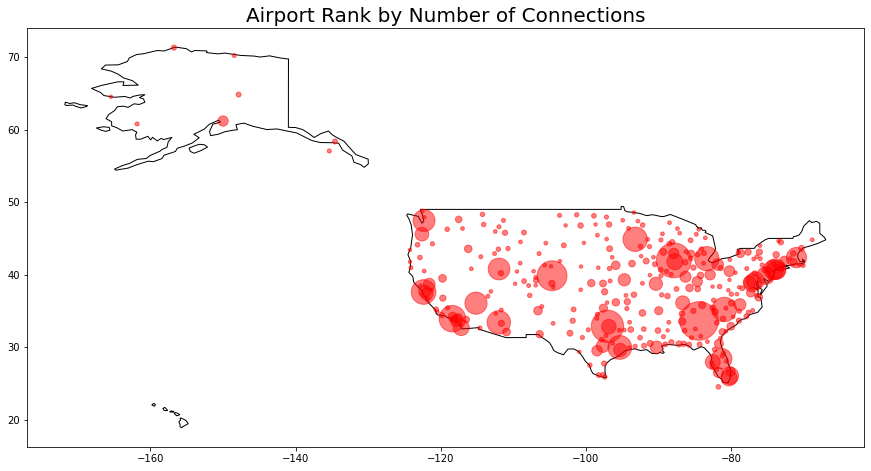

In [0]:
# Present Map for Ranking by Number of Connections
namemap, factor, color, size, title_size = 'United States of America', 25000, 'red', 15, 20
title, rank_type, label_col, Includelabel = "Airport Rank by Number of Connections", "Connec_Ranking", 'ORIGIN', False
present_Map(df1, namemap, factor, color, size, title, rank_type, label_col, title_size, Includelabel)

/databricks/python/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
 warnings.warn(

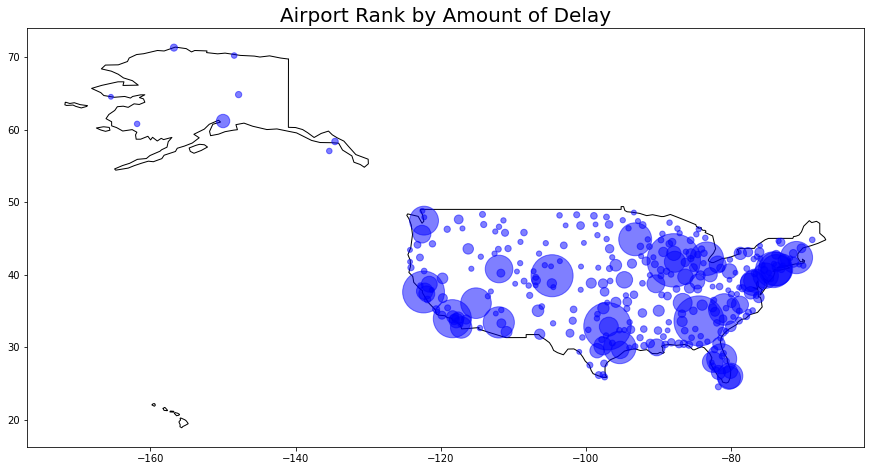

In [0]:
# Present Map for Ranking by Number of Connections
namemap, factor, color, size, title_size = 'United States of America', 50000, 'blue', 15, 20
title, rank_type, labe_col, Includelabel = "Airport Rank by Amount of Delay", "Delay_Ranking", "ORIGIN", False
present_Map(df1, namemap, factor, color, size, title, rank_type, label_col, title_size, Includelabel)

##### B. Visualization of top 5% of Airports by Number of Connections and Amount of Delays

/databricks/python/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
 warnings.warn(

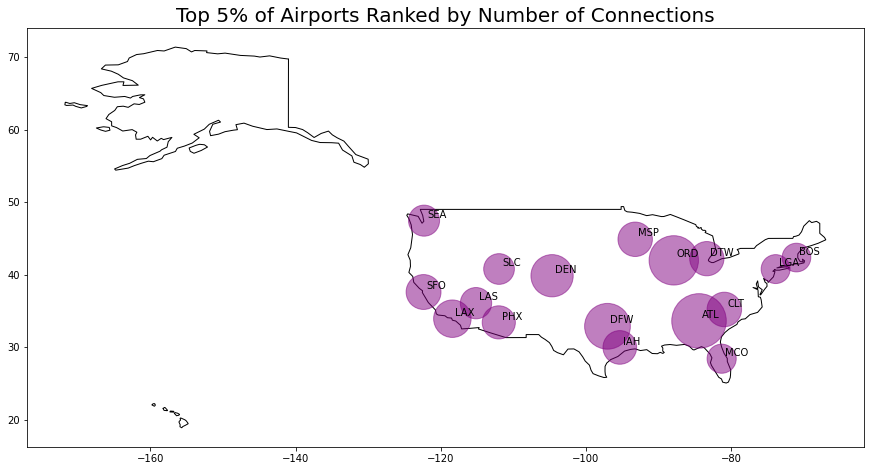

In [0]:
# Generate Map for Top Airports by Number of Connections - Group 1
df_top = df_final.filter(df_final.Cnn_Ranking_val==1)
dfF = df_top[((df_top.air_lat>=24.52) & (df_top.air_lat<=49.38) & (df_top.air_lon>=-124.77) & (df_top.air_lon<=-66.95)) | ((df_top.air_lat<=72.5) & (df_top.air_lat>=55.3) & (df_top.air_lon>=-170.7) & (df_top.air_lon<=-132.95))]
dfF = dfF.toPandas()

# Present Map for Top 5% of Airports based on Connections
namemap, factor, color, size, title_size = 'United States of America', 50000, 'purple', 15, 20
title, rank_type, label_col, Includelabel = "Top 5% of Airports Ranked by Number of Connections", "Connec_Ranking", "ORIGIN", True
present_Map(dfF, namemap, factor, color, size, title, rank_type, label_col, title_size, Includelabel)

/databricks/python/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
 warnings.warn(

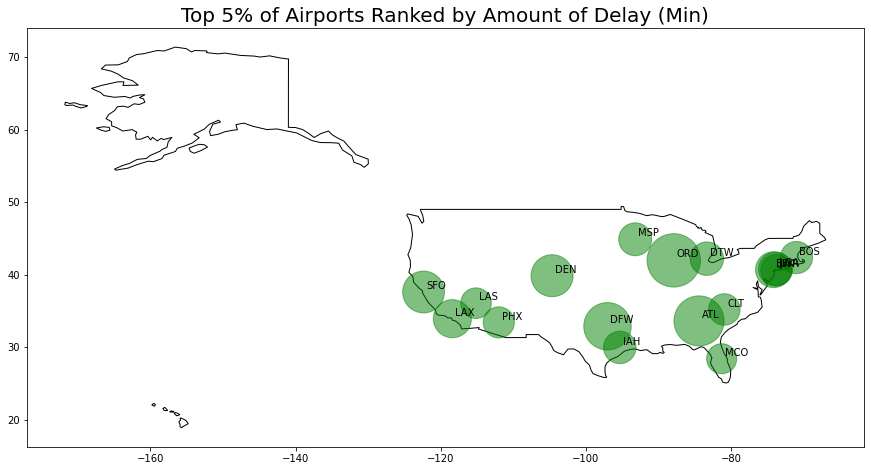

In [0]:
# Generate Map for Top Airports by Number of Connections - Group 1
df_top = df_final.filter(df_final.Delay_Ranking_val==1)
dfF = df_top[((df_top.air_lat>=24.52) & (df_top.air_lat<=49.38) & (df_top.air_lon>=-124.77) & (df_top.air_lon<=-66.95)) | ((df_top.air_lat<=72.5) & (df_top.air_lat>=55.3) & (df_top.air_lon>=-170.7) & (df_top.air_lon<=-132.95))]
dfF = dfF.toPandas()

# Present Map for Top 5% of Airports based on Connections
namemap, factor, color, size, title_size = 'United States of America', 50000, 'green', 15, 20
title, rank_type, label_col, Includelabel = "Top 5% of Airports Ranked by Amount of Delay (Min)", "Delay_Ranking", "ORIGIN", True
present_Map(dfF, namemap, factor, color, size, title, rank_type, label_col, title_size, Includelabel)

##### C. Tables for Airport Distribution by Group (Number of Connections and Amount of Delay)

In [0]:
# CHECK FOR AIRPORT SPLIT BY RANKING BASED ON NUMBER 
cnnRank = df_final.groupBy("Cnn_Ranking_val").agg( (count(col("airport"))).alias("Num_Airports"), 
                                         (sum(col("Num_connection"))).alias("Sum_Connections")  ,
                                         (sum(col("Amt_Delay"))).alias("Sum_Delay")
                                        )
cnnR = cnnRank.toPandas()
cnnR.head()

Out[125]:

Cnn_Ranking_val 
 Num_Airports 
 Sum_Connections 
 Sum_Delay 
 
 
 
 
 0 
 1 
 17 
 14753061 
 191323912.0 
 
 
 1 
 3 
 82 
 2033495 
 27331836.0 
 
 
 2 
 4 
 164 
 784653 
 10636337.0 
 
 
 3 
 2 
 65 
 11641142 
 146612251.0

In [0]:
#sort DataFrame by count descending
dfR1 = cnnR[["Cnn_Ranking_val","Sum_Connections"]].sort_values(by='Sum_Connections', ascending=False)

# #add column to display cumulative percentage
dfR1['cumperc'] = dfR1['Sum_Connections'].cumsum()/dfR1['Sum_Connections'].sum()*100

#view DataFrame
dfR1.reset_index(inplace = True)

In [0]:
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)

In [0]:
def pareto(df, title, col_sum, col_cum, ytitle1, ytitle2, grp_col, color):
    color1 = color # 'steelblue'
    color2 = 'red'
    line_size = 4

    #create basic bar plot
    fig, ax = plt.subplots(figsize=(10,5))
    ax.bar(df[grp_col], df[col_sum], color=color1)

    #add cumulative percentage line to plot
    ax2 = ax.twinx()
    ax2.plot(df[grp_col], df[col_cum], color=color2, marker="D", ms=line_size)
    ax2.yaxis.set_major_formatter(PercentFormatter())

    #specify axis colors
    ax.tick_params(axis='y', colors="black")
    ax2.tick_params(axis='y', colors="black")

    plt.xticks([1,2,3,4])
    ax.set_xlabel("Airport Group")
    ax.set_ylabel(ytitle1, fontsize=12)
    ax2.set_ylabel(ytitle2, fontsize=12)
    ax.set_title(title, fontsize=20)

    formatter = FuncFormatter(millions)

    # fig, ax = plt.subplots()
    ax.yaxis.set_major_formatter(formatter)

    #display Pareto chart
    plt.show()

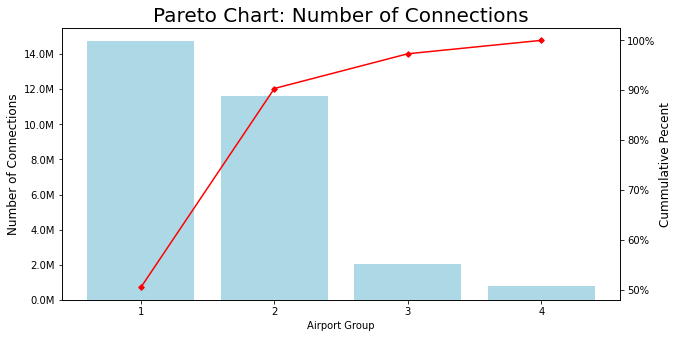

In [0]:
pareto(dfR1, "Pareto Chart: Number of Connections", "Sum_Connections", 
       "cumperc", "Number of Connections", "Cummulative Pecent", "Cnn_Ranking_val", 'lightblue')

In [0]:
# CHECK FOR AIRPORT SPLIT BY RANKING BASED ON NUMBER 
delRank = df_final.groupBy("Delay_Ranking_val").agg( (count(col("airport"))).alias("Num_Airports"), 
                                         (sum(col("Num_connection"))).alias("Sum_Connections"),
                                         (sum(col("Amt_Delay"))).alias("Sum_Delay")
                                        )

delR = delRank.toPandas()

delR.head()

Out[182]:

Delay_Ranking_val 
 Num_Airports 
 Sum_Connections 
 Sum_Delay 
 
 
 
 
 0 
 1 
 17 
 14704200 
 198906424.0 
 
 
 1 
 3 
 82 
 2006024 
 26561959.0 
 
 
 2 
 4 
 164 
 808594 
 10221134.0 
 
 
 3 
 2 
 65 
 11693533 
 140214819.0

In [0]:
#sort DataFrame by count descending
dfR2 = delR[["Delay_Ranking_val","Sum_Delay"]].sort_values(by='Sum_Delay', ascending=False)

# #add column to display cumulative percentage
dfR2['cumperc'] = dfR2['Sum_Delay'].cumsum()/dfR2['Sum_Delay'].sum()*100

#view DataFrame
dfR2.reset_index(inplace = True)

dfR2.head()

Out[184]:

index 
 Delay_Ranking_val 
 Sum_Delay 
 cumperc 
 
 
 
 
 0 
 0 
 1 
 198906424.0 
 52.914107 
 
 
 1 
 3 
 2 
 140214819.0 
 90.214773 
 
 
 2 
 1 
 3 
 26561959.0 
 97.280921 
 
 
 3 
 2 
 4 
 10221134.0 
 100.000000

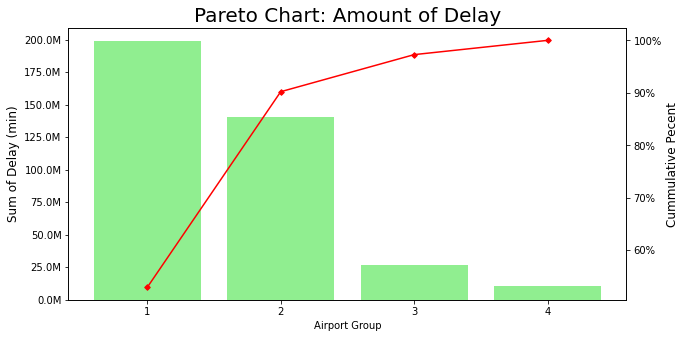

In [0]:
pareto(dfR2, "Pareto Chart: Amount of Delay", "Sum_Delay", 
       "cumperc", "Sum of Delay (min)", "Cummulative Pecent", "Delay_Ranking_val", 'lightgreen')

##### D. List of Top 5% Airport by Number of Connections and Amount of Delay

In [0]:
# Generate Map for Top Airports by Number of Connections - Group 1
df_top_Connections = df_final.filter(df_final.Cnn_Ranking_val==1)
df_top_Connections.select("airport", "Connec_Ranking", "Num_connection", "Delay_Ranking", "Amt_Delay", "ORIGIN", "ORIGIN_CITY_NAME", "ORIGIN_STATE_ABR", "ORIGIN_STATE_NM").display(10)

airport Connec_Ranking Num_connection Delay_Ranking Amt_Delay ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR ORIGIN_STATE_NM 12889 0.019640953394524752 731648 0.018754402824214776 9446013.0 LAS Las Vegas, NV NV Nevada 13487 0.02371916873187233 659920 0.021673925593545754 6923451.0 MSP Minneapolis, MN MN Minnesota 11298 0.04188303973673369 1158829 0.04500486162928415 1.648986E7 DFW Dallas/Fort Worth, TX TX Texas 14869 0.018877720922325945 501813 0.015256213974881451 4661731.0 SLC Salt Lake City, UT UT Utah 14107 0.02200685933049205 787700 0.019450786418880765 8564674.0 PHX Phoenix, AZ AZ Arizona 10397 0.05948934117247758 1865310 0.05019374447142546 2.0850924E7 ATL Atlanta, GA GA Georgia 13204 0.016966338949927193 623649 0.018075714609960686 9338584.0 MCO Orlando, FL FL Florida 10721 0.01644828148704188 630955 0.020806721316681324 9341603.0 BOS Boston, MA MA Massachusetts 14747 0.019282351968571268 642030 0.016694051085007704 6290274.0 SEA Seattle, WA WA Washington 12892 0.02811150448846267 1045707 0.029057661696983254 1.3782972E7 LAX Los Angeles, CA CA California 11292 0.03573321723558328 1090882 0.03541075086520383 1.4352267E7 DEN Denver, CO CO Colorado 12266 0.022665253417795007 744566 0.021101933070259017 9563486.0 IAH Houston, TX TX Texas 13930 0.04875923995771868 1428494 0.05709284366592733 2.2167015E7 ORD Chicago, IL IL Illinois 14771 0.024357528873913247 819507 0.035025942190241674 1.2329234E7 SFO San Francisco, CA CA California 11433 0.02351021928302974 657040 0.022490719418317068 7869691.0 DTW Detroit, MI MI Michigan 12953 0.01676883576873869 605224 0.02329964573148339 1.0142907E7 LGA New York, NY NY New York 11057 0.02386157364562147 759787 0.019904274462065885 9209226.0 CLT Charlotte, NC NC North Carolina

In [0]:
# Generate Map for Top Airports by Number of Connections - Group 1
df_top_Connections = df_final.filter(df_final.Delay_Ranking_val==1)
df_top_Connections.select("airport", "Delay_Ranking", "Amt_Delay", "Connec_Ranking", "Num_connection", "ORIGIN", "ORIGIN_CITY_NAME", "ORIGIN_STATE_ABR", "ORIGIN_STATE_NM").display(10)

airport Delay_Ranking Amt_Delay Connec_Ranking Num_connection ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR ORIGIN_STATE_NM 12889 0.018754402824214776 9446013.0 0.019640953394524752 731648 LAS Las Vegas, NV NV Nevada 13487 0.021673925593545754 6923451.0 0.02371916873187233 659920 MSP Minneapolis, MN MN Minnesota 12478 0.019354956221327903 8007184.0 0.013922794005539406 513601 JFK New York, NY NY New York 11298 0.04500486162928415 1.648986E7 0.04188303973673369 1158829 DFW Dallas/Fort Worth, TX TX Texas 14107 0.019450786418880765 8564674.0 0.02200685933049205 787700 PHX Phoenix, AZ AZ Arizona 10397 0.05019374447142546 2.0850924E7 0.05948934117247758 1865310 ATL Atlanta, GA GA Georgia 13204 0.018075714609960686 9338584.0 0.016966338949927193 623649 MCO Orlando, FL FL Florida 10721 0.020806721316681324 9341603.0 0.01644828148704188 630955 BOS Boston, MA MA Massachusetts 11618 0.02576131519591184 1.0527333E7 0.015650987080193465 581381 EWR Newark, NJ NJ New Jersey 12892 0.029057661696983254 1.3782972E7 0.02811150448846267 1045707 LAX Los Angeles, CA CA California 11292 0.03541075086520383 1.4352267E7 0.03573321723558328 1090882 DEN Denver, CO CO Colorado 12266 0.021101933070259017 9563486.0 0.022665253417795007 744566 IAH Houston, TX TX Texas 13930 0.05709284366592733 2.2167015E7 0.04875923995771868 1428494 ORD Chicago, IL IL Illinois 14771 0.035025942190241674 1.2329234E7 0.024357528873913247 819507 SFO San Francisco, CA CA California 11433 0.022490719418317068 7869691.0 0.02351021928302974 657040 DTW Detroit, MI MI Michigan 12953 0.02329964573148339 1.0142907E7 0.01676883576873869 605224 LGA New York, NY NY New York 11057 0.019904274462065885 9209226.0 0.02386157364562147 759787 CLT Charlotte, NC NC North Carolina

#### VIII - Other Code

In [0]:
# READ JOINED DATA

# NEW LINK FOR DATA FROM ZILING
df_airlines = spark.read.parquet(f"{blob_url}/mlpipeline_set_time_of_day_zl_0403").cache()

# CHECK FOR BALANCE - LARGE DATASET
# df_airlines.groupBy("DEP_DEL15").agg((count(col("DISTANCE"))).alias("COUNT_DISTANCE")).display()

df_airlines.display()

trip_id YEAR QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK OP_CARRIER_AIRLINE_ID ORIGIN_AIRPORT_ID DEST_AIRPORT_ID CRS_DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DISTANCE DISTANCE_GROUP wind_speed_mps_orig ceiling_ht_dim_orig visibility_meters_orig temp_cels_orig dew_pt_orig atmos_press_orig precip_milimeters_orig wind_speed_mps_dest ceiling_ht_dim_dest visibility_meters_dest temp_cels_dest dew_pt_dest atmos_press_dest precip_milimeters_dest rolling_ninety_day_average Air_Page_Rank_traffic Delay_block OD_delay_pair SEASON WKDAY DEPARTURE_Hour_CRS CRS_DEP_HR_INT time_of_day_int 25 2019 1 3 22 5 19393 13232 13198 1650 2.0 2.0 0.0 0 405.0 2 67.0 22000.0 1609.0 56.0 -28.0 10217.0 0 15.0 7620.0 1609.0 172.0 11.0 10220.0 0 19.002474392910578 3.757886394978127 0 13.0 1 1 16 16 4 157 2019 4 12 24 2 19393 13232 14679 1150 5.0 5.0 0.0 0 1728.0 7 15.0 7620.0 804.0 0.0 0.0 10198.0 0 0.0 427.0 1126.0 128.0 117.0 10114.0 0 11.666816389679093 3.757886394978127 0 10.0 4 1 11 11 3 814 2018 3 8 7 2 19393 12892 13232 1005 4.0 4.0 0.0 0 1750.0 8 31.0 22000.0 965.0 233.0 200.0 10087.0 0 26.0 7620.0 1609.0 267.0 200.0 10143.0 0 12.005255674148202 9.950258161703607 0 4.0 2 1 10 10 2 880 2018 3 8 3 5 19930 10713 14747 1355 -4.0 0.0 0.0 -1 399.0 2 67.0 22000.0 1609.0 250.0 28.0 10132.0 0 26.0 1067.0 1609.0 167.0 128.0 10204.0 0 10.424422172223359 0.8945969970188397 0 24.0 2 1 13 13 3 948 2018 3 8 24 5 20397 11057 11252 1754 36.0 36.0 1.0 2 416.0 2 21.0 22000.0 1609.0 267.0 122.0 10220.0 0 41.0 3353.0 1609.0 256.0 239.0 10165.0 3 19.29275800805643 8.354886887718738 1.0 36.0 2 1 17 17 5 1021 2018 3 8 10 5 19977 10693 13930 1655 6.0 6.0 0.0 0 409.0 2 41.0 2134.0 1448.0 267.0 217.0 10148.0 0 77.0 22000.0 1609.0 272.0 178.0 10137.0 0 17.9163462594749 2.780939236599366 0 0.0 2 1 16 16 4 1048 2018 3 8 23 4 20416 10721 10397 1429 -6.0 0.0 0.0 -1 946.0 4 57.0 3048.0 1609.0 222.0 106.0 10130.0 0 36.0 22000.0 1609.0 267.0 172.0 10187.0 0 19.500066921862032 5.638128599224068 0 0.0 2 1 14 14 4 1099 2018 3 8 11 6 19805 11298 14908 945 16.0 16.0 1.0 1 1205.0 5 31.0 2896.0 804.0 217.0 200.0 10151.0 51 0.0 22000.0 1609.0 233.0 133.0 10150.0 0 17.40845707820676 14.70700968027054 1.0 0.0 2 0 9 9 2 1299 2018 3 8 9 4 20304 12896 11292 1255 -4.0 0.0 0.0 -1 456.0 2 21.0 9144.0 1609.0 228.0 172.0 10171.0 0 41.0 22000.0 1609.0 222.0 94.0 10176.0 0 10.97471554993679 0.371329577576782 0 0.0 2 1 12 12 3 1312 2018 3 8 10 5 20304 13487 11337 1930 -1.0 0.0 0.0 -1 144.0 1 0.0 22000.0 1609.0 311.0 133.0 10145.0 0 31.0 22000.0 1609.0 289.0 156.0 10152.0 0 12.911317628412938 8.633914152086932 0 0.0 2 1 19 19 5 1330 2018 3 8 13 1 20304 14771 14893 1525 -8.0 0.0 0.0 -1 86.0 1 77.0 22000.0 1609.0 189.0 122.0 10156.0 0 21.0 22000.0 1126.0 294.0 133.0 10121.0 0 16.786301058140857 8.412754463419635 0 0.0 2 1 15 15 4 1347 2018 3 8 27 1 19393 10713 11884 1545 -4.0 0.0 0.0 -1 287.0 2 67.0 22000.0 1609.0 194.0 83.0 10133.0 0 51.0 1981.0 1609.0 156.0 94.0 10169.0 0 11.263019781994348 0.8945969970188397 0 0.0 2 1 15 15 4 1452 2018 3 8 8 3 20378 12266 14100 725 -3.0 0.0 0.0 -1 1325.0 6 21.0 22000.0 1609.0 267.0 250.0 10160.0 0 0.0 22000.0 1287.0 228.0 217.0 10135.0 0 12.303838677190434 8.251697506863616 0 87.0 2 1 7 7 1 1472 2018 3 8 3 5 20452 13930 11278 1205 -1.0 0.0 0.0 -1 612.0 3 26.0 22000.0 1609.0 250.0 122.0 10175.0 0 51.0 427.0 1609.0 256.0 228.0 10215.0 0 19.388877483243764 17.052259298652206 0 2.0 2 1 12 12 3 1731 2018 3 8 30 4 19393 14831 14679 1500 2.0 2.0 0.0 0 417.0 2 62.0 2591.0 1609.0 239.0 117.0 10177.0 0 51.0 22000.0 1609.0 267.0 178.0 10146.0 0 11.086024640956477 2.2621969505695128 0 0.0 2 1 15 15 4 1757 2018 3 8 27 1 20452 12953 13303 936 -1.0 0.0 0.0 -1 1096.0 5 31.0 7620.0 1609.0 250.0 200.0 10183.0 0 0.0 7620.0 1609.0 256.0 244.0 10179.0 0 20.898822322126662 5.650008393775459 0 0.0 2 1 9 9 2 1778 2018 3 8 30 4 20366 13061 12266 1608 -9.0 0.0 0.0 -1 301.0 2 41.0 22000.0 1609.0 356.0 189.0 10136.0 0 82.0 22000.0 1609.0 333.0 244.0 10155.0 0 13.783783783783784 0.2526897

In [0]:
# Load Data Including Overall Rank by Connections and Delay
airportrank = spark.read.parquet(f"{blob_url}/airportPercRank")
airportrank.display()

airport Connec_Ranking Num_connection Delay_Ranking air_lat air_lon Amt_Delay Cnn_perc_rank Delay_perc_rank Cnn_Ranking_val Delay_Ranking_val 10930 4.740152104469046E-4 152 4.743262419282238E-4 41.78020096 -124.2369995 3176.0 0.0 0.0 4 4 11415 4.740152104469046E-4 710 4.743262419282238E-4 29.3742008209 -100.927001953 9808.0 0.0 0.0 4 4 13964 4.740152104469046E-4 1329 4.743262419282238E-4 43.41709899902344 -124.24600219726562 46483.0 0.0 0.0 4 4 14120 4.740152104469046E-4 560 4.743262419282238E-4 44.38270187 -100.2860031 13105.0 0.0 0.0 4 4 11027 4.740152104469046E-4 35 4.743262419282238E-4 39.2966003418 -80.2281036377 1465.0 0.0 0.0 4 4 13873 4.740152104469046E-4 3102 4.743262419282238E-4 64.51219940185547 -165.44500732421875 18764.0 0.0 0.0 4 4 13241 4.740152104469046E-4 2584 4.743262419282238E-4 32.33259963989258 -88.75189971923828 66509.0 0.0 0.0 4 4 10361 4.740152104469046E-4 212 4.743262419282238E-4 43.99190139770508 -76.02169799804688 4209.0 0.0 0.0 4 4 14237 4.7412666487557827E-4 null 4.7476481152999964E-4 34.65449905 -112.4199982 null 0.024464831804281346 0.027522935779816515 4 4 11699 4.7540487584068407E-4 null 4.7472884265408307E-4 34.18539810180664 -79.7238998413086 null 0.027522935779816515 0.024464831804281346 4 4 12898 4.776425454663855E-4 null 4.8007165621320226E-4 40.27590179 -79.40480042 null 0.03058103975535168 0.039755351681957186 4 4 13121 4.7790827907686256E-4 133 4.787462704459892E-4 37.8582992554 -80.3994979858 1315.0 0.03363914373088685 0.03669724770642202 4 4 14905 4.780306632522159E-4 137 4.824189743865773E-4 34.89889908 -120.4570007 3136.0 0.03669724770642202 0.04892966360856269 4 4 15582 4.7957919559716444E-4 922 4.7555244017552994E-4 40.4408989 -109.5100021 15402.0 0.039755351681957186 0.03058103975535168 4 4 11315 4.8003374959528335E-4 320 4.786888553353622E-4 46.7974014282 -102.802001953 4046.0 0.04281345565749235 0.03363914373088685 4 4 12519 4.8148265716804116E-4 2327 4.835718766910193E-4 46.92969894 -98.67819977 37997.0 0.045871559633027525 0.05198776758409786 4 4 12265 4.8257508185283696E-4 null 4.810984047033508E-4 43.1072998046875 -78.94619750976562 null 0.04892966360856269 0.04281345565749235 4 4 11092 4.8345179350203223E-4 415 4.820523787190212E-4 38.75500107 -109.7549973 6648.0 0.05198776758409786 0.045871559633027525 4 4 11233 4.8376712407755543E-4 null 4.8585767528287976E-4 41.15570068 -104.8119965 null 0.05504587155963303 0.0581039755351682 4 4 13933 4.8473462732375843E-4 null 4.974095348356557E-4 42.26729965209961 -71.87570190429688 null 0.0581039755351682 0.0764525993883792 4 4 12223 4.872972046912968E-4 526 4.910093541984192E-4 38.36669922 -82.55799866 11359.0 0.06116207951070336 0.06422018348623854 4 4 12012 4.8764327902223057E-4 432 4.929075004268056E-4 38.53390121 -106.9329987 8899.0 0.06422018348623854 0.0672782874617737 4 4 12899 4.8816992288846204E-4 null 4.959189749534543E-4 41.12620163 -100.6839981 null 0.0672782874617737 0.07339449541284404 4 4 11041 4.8822015978175574E-4 623 4.840302326814648E-4 33.12829971 -117.2799988 5486.0 0.07033639143730887 0.05504587155963303 4 4 14802 4.909403736516095E-4 null 5.065653114900684E-4 38.2638015747 -78.8964004517 null 0.07339449541284404 0.09480122324159021 4 4 10558 4.932410993931145E-4 null 5.009572793260081E-4 41.87400055 -103.5960007 null 0.0764525993883792 0.08256880733944955 4 4 12343 4.935298612264898E-4 668 4.890336508283496E-4 48.566200256347656 -93.4030990600586 8808.0 0.07951070336391437 0.06116207951070336 4 4 13541 4.956073728409685E-4 707 4.954199821684879E-4 41.3931007385 -70.6143035889 14362.0 0.08256880733944955 0.07033639143730887 4 4 14004 5.003303162527813E-4 1450 5.016585283724422E-4 47.90629959 -122.2819977 24424.0 0.0856269113149847 0.0856269113149847 4 4 14716 5.048651373263782E-4 1366 5.022045258590629E-4 37.894199371338 -121.2379989624 26023.0 0.08868501529051988 0.08868501529051988 4 4 15454 5.092852501242854E-4 1010 5.346003541647822E-4 39.94269943 -91.19460297 25107.0 0.09174311926605505 0.1467889908256880

In [0]:
df_airlines = df_airlines.join(airportrank, df_airlines.ORIGIN_AIRPORT_ID ==  airportrank.airport,"left").drop(airportrank.airport)
df_airlines.display()

In [0]:
# SAVE TABLE INCLUDING THE RANKING
# Remove table if it exists
dbutils.fs.rm(f"{blob_url}/df_airlines_rank", recurse=True)

# SAVE SELECTED DATASET TO BLOB for future reference
df_airlines.write.parquet(f"{blob_url}/df_airlines_rank")

In [0]:
# READ DATA INCLUDING AIRPORT RANK.
df_rank = spark.read.parquet(f"{blob_url}/airportPercRank")
df_rank.display()

airport Connec_Ranking Num_connection Delay_Ranking air_lat air_lon Amt_Delay Cnn_perc_rank Delay_perc_rank Cnn_Ranking_val Delay_Ranking_val 10930 4.740152104469046E-4 152 4.743262419282238E-4 41.78020096 -124.2369995 3176.0 0.0 0.0 4 4 11415 4.740152104469046E-4 710 4.743262419282238E-4 29.3742008209 -100.927001953 9808.0 0.0 0.0 4 4 13964 4.740152104469046E-4 1329 4.743262419282238E-4 43.41709899902344 -124.24600219726562 46483.0 0.0 0.0 4 4 14120 4.740152104469046E-4 560 4.743262419282238E-4 44.38270187 -100.2860031 13105.0 0.0 0.0 4 4 11027 4.740152104469046E-4 35 4.743262419282238E-4 39.2966003418 -80.2281036377 1465.0 0.0 0.0 4 4 13873 4.740152104469046E-4 3102 4.743262419282238E-4 64.51219940185547 -165.44500732421875 18764.0 0.0 0.0 4 4 13241 4.740152104469046E-4 2584 4.743262419282238E-4 32.33259963989258 -88.75189971923828 66509.0 0.0 0.0 4 4 10361 4.740152104469046E-4 212 4.743262419282238E-4 43.99190139770508 -76.02169799804688 4209.0 0.0 0.0 4 4 14237 4.7412666487557827E-4 null 4.7476481152999964E-4 34.65449905 -112.4199982 null 0.024464831804281346 0.027522935779816515 4 4 11699 4.7540487584068407E-4 null 4.7472884265408307E-4 34.18539810180664 -79.7238998413086 null 0.027522935779816515 0.024464831804281346 4 4 12898 4.776425454663855E-4 null 4.8007165621320226E-4 40.27590179 -79.40480042 null 0.03058103975535168 0.039755351681957186 4 4 13121 4.7790827907686256E-4 133 4.787462704459892E-4 37.8582992554 -80.3994979858 1315.0 0.03363914373088685 0.03669724770642202 4 4 14905 4.780306632522159E-4 137 4.824189743865773E-4 34.89889908 -120.4570007 3136.0 0.03669724770642202 0.04892966360856269 4 4 15582 4.7957919559716444E-4 922 4.7555244017552994E-4 40.4408989 -109.5100021 15402.0 0.039755351681957186 0.03058103975535168 4 4 11315 4.8003374959528335E-4 320 4.786888553353622E-4 46.7974014282 -102.802001953 4046.0 0.04281345565749235 0.03363914373088685 4 4 12519 4.8148265716804116E-4 2327 4.835718766910193E-4 46.92969894 -98.67819977 37997.0 0.045871559633027525 0.05198776758409786 4 4 12265 4.8257508185283696E-4 null 4.810984047033508E-4 43.1072998046875 -78.94619750976562 null 0.04892966360856269 0.04281345565749235 4 4 11092 4.8345179350203223E-4 415 4.820523787190212E-4 38.75500107 -109.7549973 6648.0 0.05198776758409786 0.045871559633027525 4 4 11233 4.8376712407755543E-4 null 4.8585767528287976E-4 41.15570068 -104.8119965 null 0.05504587155963303 0.0581039755351682 4 4 13933 4.8473462732375843E-4 null 4.974095348356557E-4 42.26729965209961 -71.87570190429688 null 0.0581039755351682 0.0764525993883792 4 4 12223 4.872972046912968E-4 526 4.910093541984192E-4 38.36669922 -82.55799866 11359.0 0.06116207951070336 0.06422018348623854 4 4 12012 4.8764327902223057E-4 432 4.929075004268056E-4 38.53390121 -106.9329987 8899.0 0.06422018348623854 0.0672782874617737 4 4 12899 4.8816992288846204E-4 null 4.959189749534543E-4 41.12620163 -100.6839981 null 0.0672782874617737 0.07339449541284404 4 4 11041 4.8822015978175574E-4 623 4.840302326814648E-4 33.12829971 -117.2799988 5486.0 0.07033639143730887 0.05504587155963303 4 4 14802 4.909403736516095E-4 null 5.065653114900684E-4 38.2638015747 -78.8964004517 null 0.07339449541284404 0.09480122324159021 4 4 10558 4.932410993931145E-4 null 5.009572793260081E-4 41.87400055 -103.5960007 null 0.0764525993883792 0.08256880733944955 4 4 12343 4.935298612264898E-4 668 4.890336508283496E-4 48.566200256347656 -93.4030990600586 8808.0 0.07951070336391437 0.06116207951070336 4 4 13541 4.956073728409685E-4 707 4.954199821684879E-4 41.3931007385 -70.6143035889 14362.0 0.08256880733944955 0.07033639143730887 4 4 14004 5.003303162527813E-4 1450 5.016585283724422E-4 47.90629959 -122.2819977 24424.0 0.0856269113149847 0.0856269113149847 4 4 14716 5.048651373263782E-4 1366 5.022045258590629E-4 37.894199371338 -121.2379989624 26023.0 0.08868501529051988 0.08868501529051988 4 4 15454 5.092852501242854E-4 1010 5.346003541647822E-4 39.94269943 -91.19460297 25107.0 0.09174311926605505 0.1467889908256880

In [0]:
# Load Airlines Data
# df1 = spark.read.parquet("/mnt/mids-w261/datasets_final_project/parquet_airlines_data_3m/")

df1 =spark.read.parquet("/mnt/mids-w261/datasets_final_project/parquet_airlines_data/*").cache()

display(df1)

YEAR QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM OP_CARRIER_FL_NUM ORIGIN_AIRPORT_ID ORIGIN_AIRPORT_SEQ_ID ORIGIN_CITY_MARKET_ID ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR ORIGIN_STATE_FIPS ORIGIN_STATE_NM ORIGIN_WAC DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID DEST_CITY_MARKET_ID DEST DEST_CITY_NAME DEST_STATE_ABR DEST_STATE_FIPS DEST_STATE_NM DEST_WAC CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK TAXI_OUT WHEELS_OFF WHEELS_ON TAXI_IN CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED CANCELLATION_CODE DIVERTED CRS_ELAPSED_TIME ACTUAL_ELAPSED_TIME AIR_TIME FLIGHTS DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY FIRST_DEP_TIME TOTAL_ADD_GTIME LONGEST_ADD_GTIME DIV_AIRPORT_LANDINGS DIV_REACHED_DEST DIV_ACTUAL_ELAPSED_TIME DIV_ARR_DELAY DIV_DISTANCE DIV1_AIRPORT DIV1_AIRPORT_ID DIV1_AIRPORT_SEQ_ID DIV1_WHEELS_ON DIV1_TOTAL_GTIME DIV1_LONGEST_GTIME DIV1_WHEELS_OFF DIV1_TAIL_NUM DIV2_AIRPORT DIV2_AIRPORT_ID DIV2_AIRPORT_SEQ_ID DIV2_WHEELS_ON DIV2_TOTAL_GTIME DIV2_LONGEST_GTIME DIV2_WHEELS_OFF DIV2_TAIL_NUM DIV3_AIRPORT DIV3_AIRPORT_ID DIV3_AIRPORT_SEQ_ID DIV3_WHEELS_ON DIV3_TOTAL_GTIME DIV3_LONGEST_GTIME DIV3_WHEELS_OFF DIV3_TAIL_NUM DIV4_AIRPORT DIV4_AIRPORT_ID DIV4_AIRPORT_SEQ_ID DIV4_WHEELS_ON DIV4_TOTAL_GTIME DIV4_LONGEST_GTIME DIV4_WHEELS_OFF DIV4_TAIL_NUM DIV5_AIRPORT DIV5_AIRPORT_ID DIV5_AIRPORT_SEQ_ID DIV5_WHEELS_ON DIV5_TOTAL_GTIME DIV5_LONGEST_GTIME DIV5_WHEELS_OFF DIV5_TAIL_NUM 2019 3 7 31 3 2019-07-31 WN 19393 WN N908WN 555 10693 1069302 30693 BNA Nashville, TN TN 47 Tennessee 54 13487 1348702 31650 MSP Minneapolis, MN MN 27 Minnesota 63 1045 1058 13.0 13.0 0.0 0 1000-1059 10.0 1108 1254 4.0 1255 1258 3.0 3.0 0.0 0 1200-1259 0.0 null 0.0 130.0 120.0 106.0 1.0 695.0 3 null null null null null null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 2019 3 7 31 3 2019-07-31 WN 19393 WN N415WN 2300 10693 1069302 30693 BNA Nashville, TN TN 47 Tennessee 54 13487 1348702 31650 MSP Minneapolis, MN MN 27 Minnesota 63 1815 1813 -2.0 0.0 0.0 -1 1800-1859 9.0 1822 2006 11.0 2020 2017 -3.0 0.0 0.0 -1 2000-2059 0.0 null 0.0 125.0 124.0 104.0 1.0 695.0 3 null null null null null null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 2019 3 7 31 3 2019-07-31 WN 19393 WN N966WN 443 10693 1069302 30693 BNA Nashville, TN TN 47 Tennessee 54 13495 1349505 33495 MSY New Orleans, LA LA 22 Louisiana 72 1945 1953 8.0 8.0 0.0 0 1900-1959 12.0 2005 2110 2.0 2105 2112 7.0 7.0 0.0 0 2100-2159 0.0 null 0.0 80.0 79.0 65.0 1.0 471.0 2 null null null null null null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 2019 3 7 31 3 2019-07-31 WN 19393 WN N403WN 1371 10693 1069302 30693 BNA Nashville, TN TN 47 Tennessee 54 13495 1349505 33495 MSY New Orleans, LA LA 22 Louisiana 72 1330 1337 7.0 7.0 0.0 0 1300-1359 9.0 1346 1451 4.0 1505 1455 -10.0 0.0 0.0 -1 1500-1559 0.0 null 0.0 95.0 78.0 65.0 1.0 471.0 2 null null null null null null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 2019 3 7 31 3 2019-07-31 WN 19393 WN N423WN 2483 10693 1069302 30693 BNA Nashville, TN TN 47 Tennessee 54 13495 1349505 33495 MSY New Orleans, LA LA 22 Louisiana 72 745 750 5.0 5.0

In [0]:
df2 = df1.select("ORIGIN_AIRPORT_ID", "ORIGIN", "ORIGIN_CITY_NAME", "ORIGIN_STATE_ABR" ,"ORIGIN_STATE_NM").distinct()
df2.display()

ORIGIN_AIRPORT_ID ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR ORIGIN_STATE_NM 14027 PBI West Palm Beach/Palm Beach, FL FL Florida 12012 GUC Gunnison, CO CO Colorado 11778 FSM Fort Smith, AR AR Arkansas 10268 ALO Waterloo, IA IA Iowa 15323 TRI Bristol/Johnson City/Kingsport, TN TN Tennessee 10967 CGI Cape Girardeau, MO MO Missouri 14109 PIB Hattiesburg/Laurel, MS MS Mississippi 13290 MHK Manhattan/Ft. Riley, KS KS Kansas 11042 CLE Cleveland, OH OH Ohio 14122 PIT Pittsburgh, PA PA Pennsylvania 10434 AVP Scranton/Wilkes-Barre, PA PA Pennsylvania 11337 DLH Duluth, MN MN Minnesota 13485 MSN Madison, WI WI Wisconsin 11423 DSM Des Moines, IA IA Iowa 14512 RFD Rockford, IL IL Illinois 14288 PUB Pueblo, CO CO Colorado 11953 GNV Gainesville, FL FL Florida 11980 GRI Grand Island, NE NE Nebraska 12255 HYS Hays, KS KS Kansas 12016 GUM Guam, TT TT U.S. Pacific Trust Territories and Possessions 10792 BUF Buffalo, NY NY New York 13296 MHT Manchester, NH NH New Hampshire 10994 CHS Charleston, SC SC South Carolina 14679 SAN San Diego, CA CA California 10551 BET Bethel, AK AK Alaska 14321 PWM Portland, ME ME Maine 12945 LEX Lexington, KY KY Kentucky 15389 TWF Twin Falls, ID ID Idaho 15074 SWO Stillwater, OK OK Oklahoma 13422 MOB Mobile, AL AL Alabama 12448 JAN Jackson/Vicksburg, MS MS Mississippi 13891 ONT Ontario, CA CA California 14747 SEA Seattle, WA WA Washington 12402 ITO Hilo, HI HI Hawaii 10631 BJI Bemidji, MN MN Minnesota 11447 DVL Devils Lake, ND ND North Dakota 14960 SPS Wichita Falls, TX TX Texas 11481 ECP Panama City, FL FL Florida 12954 LGB Long Beach, CA CA California 13158 MAF Midland/Odessa, TX TX Texas 13241 MEI Meridian, MS MS Mississippi 11140 CRP Corpus Christi, TX TX Texas 12206 HRL Harlingen/San Benito, TX TX Texas 14709 SCC Deadhorse, AK AK Alaska 12250 HYA Hyannis, MA MA Massachusetts 12217 HSV Huntsville, AL AL Alabama 11278 DCA Washington, DC VA Virginia 13360 MLB Melbourne, FL FL Florida 14082 PGD Punta Gorda, FL FL Florida 11413 DRO Durango, CO CO Colorado 15304 TPA Tampa, FL FL Florida 10431 AVL Asheville, NC NC North Carolina 15027 STX Christiansted, VI VI U.S. Virgin Islands 13795 OAJ Jacksonville/Camp Lejeune, NC NC North Carolina 11298 DFW Dallas/Fort Worth, TX TX Texas 10136 ABI Abilene, TX TX Texas 11111 COU Columbia, MO MO Missouri 11503 EGE Eagle, CO CO Colorado 12389 ISN Williston, ND ND North Dakota 13367 MLI Moline, IL IL Illinois 14150 PLN Pellston, MI MI Michigan 11150 CSG Columbus, GA GA Georgia 15295 TOL Toledo, OH OH Ohio 10643 BKG Branson, MO MO Missouri 11540 ELP El Paso, TX TX Texas 12888 LAR Laramie, WY WY Wyoming 11259 DAL Dallas, TX TX Texas 13871 OMA Omaha, NE NE Nebraska 10245 AKN King Salmon, AK AK Alaska 11433 DTW Detroit, MI MI Michigan 15624 VPS Valparaiso, FL FL Florida 14107 PHX Phoenix, AZ AZ Arizona 13970 OTZ Kotzebue, AK AK Alaska 13851 OKC Oklahoma City, OK OK Oklahoma 15412 TYS Knoxville, TN TN Tennessee 12441 JAC Jackson, WY WY Wyoming 10333 APN Alpena, MI MI Michigan 10785 BTV Burlington, VT VT Vermont 13127 LWS Lewiston, ID ID Idaho 12129 HIB Hibbing, MN MN Minnesota 11097 COD Cody, WY WY Wyoming 12177 HOB Hobbs, NM NM New Mexico 13303 MIA Miami, FL FL Florida 11865 GCC Gillette, WY WY Wyoming 12007 GTR Columbus, MS MS Mississippi 14120 PIR Pierre, SD SD South Dakota 10918 CDC Cedar City, UT UT Utah 11618 EWR Newark, NJ NJ New Jersey 12917 LCK Columbus, OH OH Ohio 10721 BOS Boston, MA MA Massachusetts 10868 CAE Columbia, SC SC South Carolina 13983 OWB Owensboro, KY KY Kentucky 16218 YUM Yuma, AZ AZ Arizona 14814 SHV Shreveport, LA LA Louisiana 11577 ERI Erie, PA PA Pennsylvania 14524 RIC Richmond, VA VA Virginia 10299 ANC Anchorage, AK AK Alaska 14108 PIA Peoria, IL IL Illinois 15401 TXK Texarkana, AR AR Arkansas 14256 PSG Petersburg, AK AK Alaska 11995 GSO Greensboro/High Point, NC NC North Carolina 10469 AZO Kalamazoo, MI MI Michigan 11537 ELM Elmira/Corning, NY NY New York 14588 ROW Roswell, NM NM New Mexico 12889 LAS Las Vegas, NV NV Nevada 11973 GPT Gulfport/Biloxi, MS MS Missi

In [0]:
df_final = df_rank.join(df2, df_rank.airport ==  df2.ORIGIN_AIRPORT_ID,"left").drop(df2.ORIGIN_AIRPORT_ID)
df_final.display()

airport Connec_Ranking Num_connection Delay_Ranking air_lat air_lon Amt_Delay Cnn_perc_rank Delay_perc_rank Cnn_Ranking_val Delay_Ranking_val ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR ORIGIN_STATE_NM 14543 5.644326157084281E-4 1370 5.490761287916602E-4 41.5942 -109.065001 16087.0 0.18960244648318042 0.1712538226299694 4 4 RKS Rock Springs, WY WY Wyoming 10627 0.0011826401188141779 13506 0.0011933004393516547 46.772701263427734 -100.74600219726562 168513.0 0.636085626911315 0.6422018348623854 3 3 BIS Bismarck/Mandan, ND ND North Dakota 10779 5.708651843967668E-4 2159 5.415630386005309E-4 45.95479965209961 -112.49700164794922 23621.0 0.20795107033639143 0.15902140672782875 4 4 BTM Butte, MT MT Montana 12402 0.0012036437110764277 26908 7.114364735888737E-4 19.721399307250977 -155.04800415039062 106740.0 0.6513761467889908 0.40672782874617736 3 4 ITO Hilo, HI HI Hawaii 10620 9.466162475002569E-4 15786 8.576755326697165E-4 45.807701110839844 -108.54299926757812 128895.0 0.5504587155963303 0.5137614678899083 3 3 BIL Billings, MT MT Montana 10431 0.0012921315774102708 23720 0.0013192749090157024 35.43619918823242 -82.54180145263672 395198.0 0.672782874617737 0.6819571865443425 3 3 AVL Asheville, NC NC North Carolina 11638 0.001586227334281171 43496 0.001603809531141347 36.77619934082031 -119.71800231933594 624536.0 0.7155963302752294 0.7247706422018348 3 3 FAT Fresno, CA CA California 13964 4.740152104469046E-4 1329 4.743262419282238E-4 43.41709899902344 -124.24600219726562 46483.0 0.0 0.0 4 4 OTH North Bend/Coos Bay, OR OR Oregon 10141 5.676121248442883E-4 3525 5.688750120378883E-4 45.449100494384766 -98.42179870605469 48045.0 0.19571865443425077 0.2018348623853211 4 4 ABR Aberdeen, SD SD South Dakota 14794 6.581510517343159E-4 7384 5.698994821296082E-4 37.036389 -113.510306 61422.0 0.3302752293577982 0.21100917431192662 4 4 SGU St. George, UT UT Utah 13871 0.002969363534380333 96430 0.002744229889490054 41.3032 -95.894096 1088598.0 0.8256880733944955 0.8195718654434251 2 2 OMA Omaha, NE NE Nebraska 12889 0.019640953394524752 731648 0.018754402824214776 36.08010101 -115.1520004 9446013.0 0.9663608562691132 0.9541284403669725 1 1 LAS Las Vegas, NV NV Nevada 13487 0.02371916873187233 659920 0.021673925593545754 44.882 -93.221802 6923451.0 0.9785932721712538 0.9724770642201835 1 1 MSP Minneapolis, MN MN Minnesota 13230 0.001010397536274445 18148 9.635239625053716E-4 40.1935005188 -76.7633972168 244345.0 0.581039755351682 0.581039755351682 3 3 MDT Harrisburg, PA PA Pennsylvania 12448 0.001296180492917738 31358 0.0011351289305936312 32.3111991882 -90.0758972168 389172.0 0.6758409785932722 0.6238532110091743 3 3 JAN Jackson/Vicksburg, MS MS Mississippi 13241 4.740152104469046E-4 2584 4.743262419282238E-4 32.33259963989258 -88.75189971923828 66509.0 0.0 0.0 4 4 MEI Meridian, MS MS Mississippi 11617 6.392860574499042E-4 5414 6.273880117677469E-4 35.0730018616 -77.04290008539999 74288.0 0.29357798165137616 0.3241590214067278 4 4 EWN New Bern/Morehead/Beaufort, NC NC North Carolina 12891 6.512416281951056E-4 5752 6.458092910236704E-4 34.5676994324 -98.4166030884 82354.0 0.3180428134556575 0.3516819571865443 4 4 LAW Lawton/Fort Sill, OK OK Oklahoma 11982 8.316940203123993E-4 13723 7.455241245700782E-4 31.067199707 -97.82890319820001 174669.0 0.4740061162079511 0.4434250764525994 4 4 GRK Killeen, TX TX Texas 13127 5.770042385395114E-4 2360 5.139245820549564E-4 46.3745002746582 -117.01499938964844 13186.0 0.22018348623853212 0.10397553516819572 4 4 LWS Lewiston, ID ID Idaho 11953 8.766906104291027E-4 15047 8.178454767719277E-4 29.6900997162 -82.2717971802 212062.0 0.5107033639143731 0.48623853211009177 3 4 GNV Gainesville, FL FL Florida 13303 0.010395249795284294 366257 0.010537135338164005 25.79319953918457 -80.29060363769531 5340685.0 0.926605504587156 0.9296636085626911 2 2 MIA Miami, FL FL Florida 10466 0.0015427052830907864 1092 0.0015937554279342062 33.30780029 -111.6549988 10882.0 0.7064220183486238 0.7217125382262997 3 3 AZA Phoenix, AZ A

In [0]:
# Remove table if it exists
dbutils.fs.rm(f"{blob_url}/airportPercRank_Names", recurse=True)

# SAVE SELECTED DATASET TO BLOB for future reference
df_final.write.parquet(f"{blob_url}/airportPercRank_Names")

In [0]:
df_top = df_final.filter(df_final.Delay_Ranking_val==1)

Out[31]:

airport 
 Connec_Ranking 
 Num_connection 
 Delay_Ranking 
 air_lat 
 air_lon 
 Amt_Delay 
 Cnn_perc_rank 
 Delay_perc_rank 
 Cnn_Ranking_val 
 Delay_Ranking_val 
 ORIGIN 
 ORIGIN_CITY_NAME 
 ORIGIN_STATE_ABR 
 ORIGIN_STATE_NM 
 
 
 
 
 0 
 12889 
 0.019641 
 731648 
 0.018754 
 36.080101 
 -115.152000 
 9446013.0 
 0.966361 
 0.954128 
 1 
 1 
 LAS 
 Las Vegas, NV 
 NV 
 Nevada 
 
 
 1 
 13487 
 0.023719 
 659920 
 0.021674 
 44.882000 
 -93.221802 
 6923451.0 
 0.978593 
 0.972477 
 1 
 1 
 MSP 
 Minneapolis, MN 
 MN 
 Minnesota 
 
 
 2 
 12478 
 0.013923 
 513601 
 0.019355 
 40.639801 
 -73.778900 
 8007184.0 
 0.944954 
 0.957187 
 2 
 1 
 JFK 
 New York, NY 
 NY 
 New York 
 
 
 3 
 11298 
 0.041883 
 1158829 
 0.045005 
 32.896801 
 -97.038002 
 16489860.0 
 0.993884 
 0.993884 
 1 
 1 
 DFW 
 Dallas/Fort Worth, TX 
 TX 
 Texas 
 
 
 4 
 14107 
 0.022007 
 787700 
 0.019451 
 33.434299 
 -112.012001 
 8564674.0 
 0.969419 
 0.960245 
 1 
 1 
 PHX 
 Phoenix, AZ 
 AZ 
 Arizona

#### IX - Feature Engineering : Lagged Page Rank weighted by delays split by year and time-of-day

This is a feature generated from a weighted Page Rank implemented from scratch. The Page Rank is weighted by departure delays in minutes from the airport and page rank is executed for 35 splits of the data by year (5 years) and time-of-day (7 parts of the day). A computed page rank is then lagged by a year for 2016-2019 within each time of day category while average weighted page rank by delay for 2015-2019 is imputed for 2015 records. This is then joined to the main dataset by origin airport, year and time of day. We were interested to create this page rank metric weighted by prior delay to emphasize airports which have disproportionate influence in delays across the network and to use the time of day splits to prove our theory from our EDA that airport delays accumulate over the course of the day and reset at the start of the next day.

In [0]:
#Read in dataset for ML pipeline with time of day feature in categorical numbers

df_airlines = spark.read.parquet(f"{blob_url}/mlpipeline_set_time_of_day_zl_0403").cache()


In [0]:
#Convert time of day string into integer and drop the original time of day column

df_airlines = df_airlines.withColumn("time_of_day_int1",df_airlines.time_of_day_int.cast(IntegerType()))
df_airlines = df_airlines.drop('time_of_day_int')
df_airlines = df_airlines.withColumnRenamed('time_of_day_int1','time_of_day')


In [0]:
#Create two lists each containing 35 names for dataframe objects (5 years and 7 times-of-day)

#This will hold the 35 names for dataframes that contain the variables needed for the page rank weighted by delays
df_list = []

#This will hold the 35 names for the outcome dataframes that will contain the airport name and the delay weighted page rank prior to lag
delay_df_list = []
for y in range(2015,2020):
    for tod in range(1,8):
        globals()['df_' + str(y) +str('_')+ str(tod)] =  df_airlines.filter( (df_airlines.YEAR  == y) & (df_airlines.time_of_day  == tod) )
        df_list.append(('df_' + str(y) +str('_')+ str(tod))) 
        delay_df_list.append(('delay_df_' + str(y) +str('_')+ str(tod))) 

In [0]:
#Create a wrapper function to map this weighted page rank to each of the 35 dataframes

def pgrnk_weighted_delay(df):
    df = df.select("ORIGIN_AIRPORT_ID", "DEST_AIRPORT_ID", "DEP_DELAY_NEW")
    airpRDD_delay = connections_weight(df).cache()
    airpdelay = airpRDD_delay.flatMap(lambda x: calc_cnn(x)).cache()
    colnames = ["airport", "N_Air_to", "Amt_Delay"]
    airport_delay = airpdelay.toDF(colnames)
    Nnodes_delay = count_nodes(airpRDD_delay)
    # Initialize Graph
    init_graph_delay = initGraph(airpRDD_delay)

    # Get Page Rank
    nIter = 10
    start = time.time()
    graph_delay = runPageRank(init_graph_delay, alpha = 0.15, maxIter = nIter, verbose = True)
    
    airportDelayRank = graph_delay.toDF(["airport", "Delay_Ranking"])
    
    return airportDelayRank 
    

    
    

In [0]:
#Drop NAs from dataframes with NA values

df_2017_5 = df_2017_5.dropna()
df_2018_1 = df_2018_1.dropna()
df_2018_2 = df_2018_2.dropna()
df_2018_3 = df_2018_3.dropna()
df_2018_4 = df_2018_4.dropna()
df_2018_5 = df_2018_5.dropna()
df_2018_6 = df_2018_6.dropna()
df_2018_7 = df_2018_7.dropna()

In [0]:
#Apply weighted pagerank by delay function to all 35 dataframes and create 35 delay page rank outcome dataframes
for i in range(len(delay_df_list)):
    globals()[delay_df_list[i]]= pgrnk_weighted_delay(globals()[df_list[i]])
    

In [0]:
#Checkpoint and save to blob storage prior to performing lag operation

delay_df_2015_1 = spark.read.parquet(f"{blob_url}/pgrank_tod_delay/delay_df_2015_1")
delay_df_2015_2 = spark.read.parquet(f"{blob_url}/pgrank_tod_delay/delay_df_2015_2")
delay_df_2015_3 = spark.read.parquet(f"{blob_url}/pgrank_tod_delay/delay_df_2015_3")
delay_df_2015_4 = spark.read.parquet(f"{blob_url}/pgrank_tod_delay/delay_df_2015_4")
delay_df_2015_5 = spark.read.parquet(f"{blob_url}/pgrank_tod_delay/delay_df_2015_5")
delay_df_2015_6 = spark.read.parquet(f"{blob_url}/pgrank_tod_delay/delay_df_2015_6")
delay_df_2015_7 = spark.read.parquet(f"{blob_url}/pgrank_tod_delay/delay_df_2015_7")

delay_df_2015_1 = delay_df_2015_1.cache()
delay_df_2015_2 = delay_df_2015_2.cache()
delay_df_2015_3 = delay_df_2015_4.cache()
delay_df_2015_4 = delay_df_2015_4.cache()
delay_df_2015_5 = delay_df_2015_5.cache()
delay_df_2015_6 = delay_df_2015_6.cache()
delay_df_2015_7 = delay_df_2015_7.cache()

delay_df_2016_1 = spark.read.parquet(f"{blob_url}/pgrank_tod_delay/delay_df_2016_1")
delay_df_2016_2 = spark.read.parquet(f"{blob_url}/pgrank_tod_delay/delay_df_2016_2")
delay_df_2016_3 = spark.read.parquet(f"{blob_url}/pgrank_tod_delay/delay_df_2016_3")
delay_df_2016_4 = spark.read.parquet(f"{blob_url}/pgrank_tod_delay/delay_df_2016_4")
delay_df_2016_5 = spark.read.parquet(f"{blob_url}/pgrank_tod_delay/delay_df_2016_5")
delay_df_2016_6 = spark.read.parquet(f"{blob_url}/pgrank_tod_delay/delay_df_2016_6")
delay_df_2016_7 = spark.read.parquet(f"{blob_url}/pgrank_tod_delay/delay_df_2016_7")

delay_df_2016_1 = delay_df_2016_1.cache()
delay_df_2016_2 = delay_df_2016_2.cache()
delay_df_2016_3 = delay_df_2016_4.cache()
delay_df_2016_4 = delay_df_2016_4.cache()
delay_df_2016_5 = delay_df_2016_5.cache()
delay_df_2016_6 = delay_df_2016_6.cache()
delay_df_2016_7 = delay_df_2016_7.cache()


delay_df_2017_1 = spark.read.parquet(f"{blob_url}/pgrank_tod_delay/delay_df_2017_1")
delay_df_2017_2 = spark.read.parquet(f"{blob_url}/pgrank_tod_delay/delay_df_2017_2")
delay_df_2017_3 = spark.read.parquet(f"{blob_url}/pgrank_tod_delay/delay_df_2017_3")
delay_df_2017_4 = spark.read.parquet(f"{blob_url}/pgrank_tod_delay/delay_df_2017_4")
delay_df_2017_5 = spark.read.parquet(f"{blob_url}/pgrank_tod_delay/delay_df_2017_5")
delay_df_2017_6 = spark.read.parquet(f"{blob_url}/pgrank_tod_delay/delay_df_2017_6")
delay_df_2017_7 = spark.read.parquet(f"{blob_url}/pgrank_tod_delay/delay_df_2017_7")

delay_df_2017_1 = delay_df_2017_1.cache()
delay_df_2017_2 = delay_df_2017_2.cache()
delay_df_2017_3 = delay_df_2017_4.cache()
delay_df_2017_4 = delay_df_2017_4.cache()
delay_df_2017_5 = delay_df_2017_5.cache()
delay_df_2017_6 = delay_df_2017_6.cache()
delay_df_2017_7 = delay_df_2017_7.cache()


delay_df_2018_1 = spark.read.parquet(f"{blob_url}/pgrank_tod_delay/delay_df_2018_1")
delay_df_2018_2 = spark.read.parquet(f"{blob_url}/pgrank_tod_delay/delay_df_2018_2")
delay_df_2018_3 = spark.read.parquet(f"{blob_url}/pgrank_tod_delay/delay_df_2018_3")
delay_df_2018_4 = spark.read.parquet(f"{blob_url}/pgrank_tod_delay/delay_df_2018_4")
delay_df_2018_5 = spark.read.parquet(f"{blob_url}/pgrank_tod_delay/delay_df_2018_5")
delay_df_2018_6 = spark.read.parquet(f"{blob_url}/pgrank_tod_delay/delay_df_2018_6")
delay_df_2018_7 = spark.read.parquet(f"{blob_url}/pgrank_tod_delay/delay_df_2018_7")

delay_df_2018_1 = delay_df_2018_1.cache()
delay_df_2018_2 = delay_df_2018_2.cache()
delay_df_2018_3 = delay_df_2018_4.cache()
delay_df_2018_4 = delay_df_2018_4.cache()
delay_df_2018_5 = delay_df_2018_5.cache()
delay_df_2018_6 = delay_df_2018_6.cache()
delay_df_2018_7 = delay_df_2018_7.cache()

delay_df_2019_1 = spark.read.parquet(f"{blob_url}/pgrank_tod_delay/delay_df_2019_1")
delay_df_2019_2 = spark.read.parquet(f"{blob_url}/pgrank_tod_delay/delay_df_2019_2")
delay_df_2019_3 = spark.read.parquet(f"{blob_url}/pgrank_tod_delay/delay_df_2019_3")
delay_df_2019_4 = spark.read.parquet(f"{blob_url}/pgrank_tod_delay/delay_df_2019_4")
delay_df_2019_5 = spark.read.parquet(f"{blob_url}/pgrank_tod_delay/delay_df_2019_5")
delay_df_2019_6 = spark.read.parquet(f"{blob_url}/pgrank_tod_delay/delay_df_2019_6")
delay_df_2019_7 = spark.read.parquet(f"{blob_url}/pgrank_tod_delay/delay_df_2019_7")

delay_df_2019_1 = delay_df_2019_1.cache()
delay_df_2019_2 = delay_df_2019_2.cache()
delay_df_2019_3 = delay_df_2019_4.cache()
delay_df_2019_4 = delay_df_2019_4.cache()
delay_df_2019_5 = delay_df_2019_5.cache()
delay_df_2019_6 = delay_df_2019_6.cache()
delay_df_2019_7 = delay_df_2019_7.cache()


In [0]:
# Create Year and Time of day columns for each of these 35 dataframes

year_count = int(2015)
time_of_day = int(1)
for i in range(len(delay_df_list)):
             globals()[delay_df_list[i]]= globals()[delay_df_list[i]].withColumn('WIP_YEAR',lit(year_count))
             globals()[delay_df_list[i]]= globals()[delay_df_list[i]].withColumn('WIP_TOD',lit(time_of_day))
             print(year_count)
             print(time_of_day)
             time_of_day +=1
             if time_of_day==8:
                 year_count +=1
                 time_of_day = int(1)
             

In [0]:
#Join all 35 tables together

delay_allyears_alltod = delay_df_2015_1

for i in range(1,35):
    delay_allyears_alltod = delay_allyears_alltod.union(globals()[delay_df_list[i]])


In [0]:
#Rename columns, can be written as select statement without chaining to optimize but given that this takes 0.04 seconds to run that is not necessary

delay_allyears_alltod= delay_allyears_alltod.withColumnRenamed('WIP_YEAR','UNION_YEAR').withColumnRenamed('WIP_TOD','UNION_TOD')

In [0]:
#Create Lagged Year column to facilitate Joins later

delay_allyears_alltod= delay_allyears_alltod.withColumn("UNION_YEAR_WITH_LAG", (F.col('UNION_YEAR')-1))

#Mark Delay Ranking without lag for subsequent dropping
delay_allyears_alltod= delay_allyears_alltod.withColumn("UNION_YEAR_WITH_LAG", (F.col('UNION_YEAR')-1))



In [0]:
#Calculate Average delay ranking across all years and time of day by airport

avg_table = delay_allyears_alltod.groupBy("airport").agg(avg(col("Delay_Ranking_to_drop")).alias("Avg_Rank") )
avg_table = avg_table.withColumnRenamed('airport','avg_table_airport_name')
display(avg_table.limit(10))


In [0]:
#Join average delay table to delay page rank table
cond10 = [(delay_allyears_alltod.airport == avg_table.avg_table_airport_name) ]
delay_allyears_alltod = delay_allyears_alltod.join(avg_table, cond10, 'leftouter')

In [0]:
#Rename column in joined table
delay_allyears_alltod = delay_allyears_alltod.withColumnRenamed('airport','airport_Union')


In [0]:
#Create another combined delay page rank table without lag for joining

delay_allyears_for_joining = delay_df_2015_1

for i in range(1,35):
    delay_allyears_for_joining = delay_allyears_for_joining.union(globals()[delay_df_list[i]])

In [0]:
#Now join the two delay page rank tables on airport, time of day and join lagged year with non-lagged year in other words 2015 gets joined to 2016 record

cond11 = [(delay_allyears_alltod.airport_Union == delay_allyears_for_joining.airport) & (delay_allyears_alltod.UNION_YEAR_WITH_LAG == delay_allyears_for_joining.WIP_YEAR)  & (delay_allyears_alltod.UNION_TOD == delay_allyears_for_joining.WIP_TOD)]

delay_allyears_alltod = delay_allyears_alltod.join(delay_allyears_for_joining, cond11, 'leftouter')



In [0]:
#Checkpoint
delay_allyears_alltod.write.parquet(f"{blob_url}/pgrankdelays_tod_yr_prior_to_coalesce")

In [0]:
#Use coalesce to fill in null value columns (2015 records) with the average across all years

    
delay_allyears_alltod= delay_allyears_alltod.withColumn("Coalesced_PgRank",coalesce(delay_allyears_alltod.Delay_Ranking,delay_allyears_alltod.Avg_Rank)) 

In [0]:
#View Null items
display(delay_allyears_alltod.select("airport_Union","UNION_YEAR","airport","UNION_TOD").filter(col("airport").isNull()).distinct())

In [0]:
#Checkpoint
delay_allyears_alltod.write.parquet(f"{blob_url}/pgrankdelays_tod_yr_after_coalesce_before_clean")

In [0]:
#Drop columns that are not needed for example duplicate columns or Delay Ranking without lag column

delay_allyears_alltod1 = delay_allyears_alltod.drop('Delay_Ranking_to_drop','UNION_YEAR_WITH_LAG','avg_table_airport_name','Avg_Rank','airport','Delay_Ranking','WIP_YEAR','WIP_TOD')

In [0]:
#check for Nas
delay_allyears_alltod1.count()

In [0]:
#there are no more Nas
delay_allyears_alltod1.dropna().count()

In [0]:
#Checkpoint and save
delay_allyears_alltod1.write.parquet(f"{blob_url}/final_pgrankdelays_tod_yr")

#### X - Feature Engineering : Lagged Page Rank weighted by connections (number of flights) split by year and time-of-day

In [0]:
#df_list = []
conn_df_list = []
for y in range(2015,2020):
    for tod in range(1,8):
        globals()['df_' + str(y) +str('_')+ str(tod)] =  df_airlines.filter( (df_airlines.YEAR  == y) & (df_airlines.time_of_day  == tod) )
        #df_list.append(('df_' + str(y) +str('_')+ str(tod))) 
        conn_df_list.append(('conn_df_' + str(y) +str('_')+ str(tod))) 

In [0]:
def pgrnk_weighted_conn(df):
    df = df.select("ORIGIN_AIRPORT_ID", "DEST_AIRPORT_ID")
    df = df.withColumn("connection", lit(1)) 
    airportsRDD_conn = connections_weight(df).cache()

    arpcnn = airportsRDD_conn.flatMap(lambda x: calc_cnn(x)).cache()
    colnames = ["airport", "N_Air_to", "Num_connection"]
    airport_conn = arpcnn.toDF(colnames)
    Nnodes_delay = count_nodes(airportsRDD_conn)

    # Initialize Graph
    init_graph_connections = initGraph(airportsRDD_conn)

    # Get Page Rank
    nIter = 10
    start = time.time()
    graph_connections = runPageRank(init_graph_connections, alpha = 0.15, maxIter = nIter, verbose = True)
    airportConnRank = graph_connections.toDF(["airport", "Conn_Ranking"])
    return airportConnRank

In [0]:
for i in range(len(conn_df_list)):
    globals()[conn_df_list[i]]= pgrnk_weighted_conn(globals()[df_list[i]])

In [0]:
conn_df_2015_1.write.parquet(f"{blob_url}/pgrank_tod_conn/conn_df_2015_1")
conn_df_2015_2.write.parquet(f"{blob_url}/pgrank_tod_conn/conn_df_2015_2")
conn_df_2015_3.write.parquet(f"{blob_url}/pgrank_tod_conn/conn_df_2015_3")
conn_df_2015_4.write.parquet(f"{blob_url}/pgrank_tod_conn/conn_df_2015_4")
conn_df_2015_5.write.parquet(f"{blob_url}/pgrank_tod_conn/conn_df_2015_5")
conn_df_2015_6.write.parquet(f"{blob_url}/pgrank_tod_conn/conn_df_2015_6")
conn_df_2015_7.write.parquet(f"{blob_url}/pgrank_tod_conn/conn_df_2015_7")

In [0]:
for i in range(7,35):
    globals()[conn_df_list[i]].write.parquet(f"{blob_url}/pgrank_tod_conn/" + conn_df_list[i])

In [0]:
# Test to see if the data is in the blob
temp = spark.read.parquet(f"{blob_url}/pgrank_tod_conn/conn_df_2019_7").cache()
temp.display()